In [ ]:
#Instalando pacotes e atualizacoes necessarias

!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install mapclassify

In [2]:
#Importando pacotes e dados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import geopandas as geo
from geopandas import GeoDataFrame
import mapclassify as map
import seaborn as sns

In [ ]:
#Código para baixar csv de emissões GEE direto do drive
!gdown -- 1i_RebQCAJ2Jd0wHB0NEEErKnaJAIWnsz

#Código para baixar csv de transição bioma (mudança uso do solo) direto do drive
!gdown -- 1Ah-8XmRGkYpm4OsS1UrZsU1mUi-pNNxP


#!gdown -- 1i_RebQCAJ2Jd0wHB0NEEErKnaJAIWnsz
!gdown -- 1Ah-8XmRGkYpm4OsS1UrZsU1mUi-pNNxP
!gdown -- 1bwXArivXuNntF2rA1V1--_jFlRePFhA7

#Documentos dos limites geograficos das unidades federativas do Brasil 
#(o trabalhavel e um shapefile, mas os demais tambem devem ser baixados)
!gdown -- 11FiQyjlYgYxn6ExZoB1HhXKXqaqFxOgV
!gdown -- 1A4s2nwWI4zTdEbZQBxqojIrPUS1mRbKE
!gdown -- 1H2E14BeLdNNbSJsdlH6FLHmC-YEkkW9g
!gdown -- 1bwXArivXuNntF2rA1V1--_jFlRePFhA7
!gdown -- 1x3QTYb5cbQYTPeQqJ-ZNU-gnWyB-trHh

In [4]:
trans_bioma_est = pd.read_csv('/content/transicao_estado_bioma_de_para_anual.csv')
gases_est = pd.read_csv('/content/emissao_gee_uf.csv')
#queimadas = pd.read_csv('~/Focos_2022-08-18_2022-08-19.csv')

gdf_estados = geo.read_file('/content/BR_UF_2021.shp').rename(columns={'SIGLA':'sigla_uf'})

In [9]:
#Os dados de gases, para antes de 1990, não consideram as 
#fontes de mudança de uso do solo e não são comparáveis, e os dados de mudança do uso
#do solo só vão até 2019. Por isso, usamos apenas o recorte de 90-19


bioma_90_19 = trans_bioma_est[(trans_bioma_est["ano"] > 1989) & (trans_bioma_est["ano"] < 2020)]
bioma_90_19 = bioma_90_19.drop(columns=['de_id_classe', 'para_id_classe'])


#Analisando apenas o nivel de mudanca 0 (contém apenas antropico, natural e nao identificado)

df_bioma_n0 = bioma_90_19.groupby(['ano', 'sigla_uf', 'de_nivel_0', 'para_nivel_0'], as_index=False)['area'].sum()
df_bioma_n0 = df_bioma_n0.set_index('sigla_uf')

#Analisando as mudancas de nivel 1

df_bioma_n1 = bioma_90_19.groupby(['ano', 'sigla_uf', 'de_nivel_1', 'para_nivel_1'], as_index=False)['area'].sum()
df_bioma_n1 = df_bioma_n1.set_index('sigla_uf')

In [10]:
#Criando um dicionário com as áreas dos estados.
#Esses dados são usados para corrigir as áreas de conversão e de emissão de GEE mais a frente

areas_est_dict = {'PA': 1245870, 'RO': 237765, 'AC': 164123, 'AM': 1559168, 'RR': 223644, 'AP': 142471, 
             'MT': 903207, 'MS': 357145, 'GO': 340203, 'TO': 277467, 'DF': 5761, 'BA': 564760, 
             'MA': 329642, 'PI': 251756, 'CE': 148894, 'PE': 98068, 'PB': 56467, 'RN': 52810, 
             'AL': 27843, 'SE': 21925, 'PR': 199298, 'RS': 281707, 'SC': 95731,
             'SP': 248219, 'MG': 586521, 'ES': 46074, 'RJ': 43750}

area_estados = pd.DataFrame.from_dict(areas_est_dict, orient='index')
estados = area_estados.index.tolist()
print(estados)

['PA', 'RO', 'AC', 'AM', 'RR', 'AP', 'MT', 'MS', 'GO', 'TO', 'DF', 'BA', 'MA', 'PI', 'CE', 'PE', 'PB', 'RN', 'AL', 'SE', 'PR', 'RS', 'SC', 'SP', 'MG', 'ES', 'RJ']


In [11]:

##NIVEL 0: ANTROPICO <-> NATURAL
#Normalizando as areas de mudancas de solo pelas areas totais de cada estado (os dados do MapBiomas, de transicao, 
#estavam em hec: 1 hec = 0,01 km^2. Os dados finais ja estao em porcentagem, sem medida)


#Essa alça faz uso da lista com áreas dos estados

for x in estados:
  df_bioma_n0.loc[x, 'area1'] = df_bioma_n0.loc[x,'area']/area_estados.loc[x][0]

#Segregando dados por de_nivel_0 = antropico -> natural

df_annt = df_bioma_n0.loc[(df_bioma_n0['de_nivel_0'] == 'antropico') & (df_bioma_n0['para_nivel_0'] == 'natural')]



#Segregando dados por de_nivel_0 = natural -> antropico

df_ntan = df_bioma_n0.loc[(df_bioma_n0['de_nivel_0'] == 'natural') & (df_bioma_n0['para_nivel_0'] == 'antropico')]


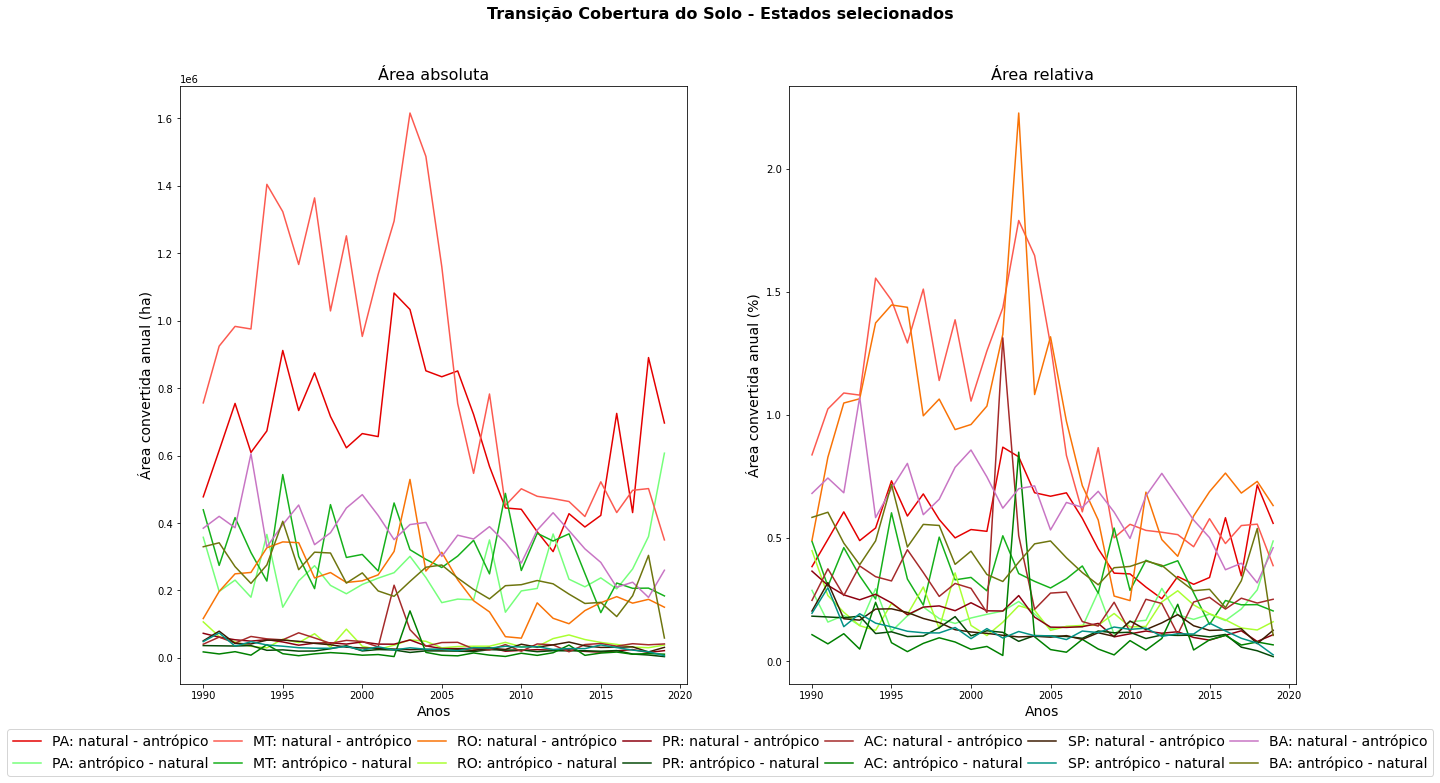

In [12]:
##PLOTANDO OS DADOS DE ESTADOS SELECIONADOS
#PARA ANALISAR O EFEITO DA CORRECAO POR TERRITORIO DO ESTADO

#Estados selecionados
#Iremos analisar alguns estados particulares ao longo dos anos,
#assim como o efeito da normalização dos valores pelo terrotório total do estado

#Plotando os dois graficos num único eixo, lado a lado

fig, ax = plt.subplots(1,2, figsize=(20, 11))
plt.rcParams.update({'font.size': 14})

#Definindo o eixo 0 (i.e., areas absolutas), com seus dados e legendas
ax[0].plot(df_ntan.loc['PA'].ano, df_ntan.loc['PA'].area, label='PA: natural - antrópico', color='xkcd:red')
ax[0].plot(df_annt.loc['PA'].ano, df_annt.loc['PA'].area, label='PA: antrópico - natural', color='xkcd:lightgreen')

ax[0].plot(df_ntan.loc['MT'].ano, df_ntan.loc['MT'].area, label='MT: natural - antrópico', color='xkcd:coral')
ax[0].plot(df_annt.loc['MT'].ano, df_annt.loc['MT'].area, label='MT: antrópico - natural', color='xkcd:green')

ax[0].plot(df_ntan.loc['RO'].ano, df_ntan.loc['RO'].area, label='RO: natural - antrópico', color='xkcd:orange')
ax[0].plot(df_annt.loc['RO'].ano, df_annt.loc['RO'].area, label='RO: antrópico - natural', color='xkcd:lime')         
         
ax[0].plot(df_ntan.loc['PR'].ano, df_ntan.loc['PR'].area, label='PR: natural - antrópico', color='xkcd:crimson', )
ax[0].plot(df_annt.loc['PR'].ano, df_annt.loc['PR'].area, label='PR: antrópico - natural', color='xkcd:darkgreen')        
         
ax[0].plot(df_ntan.loc['AC'].ano, df_ntan.loc['AC'].area, label='AC: natural - antrópico', color='brown')
ax[0].plot(df_annt.loc['AC'].ano, df_annt.loc['AC'].area, label='AC: antrópico - natural', color='green')  
       
ax[0].plot(df_ntan.loc['SP'].ano, df_ntan.loc['SP'].area, label='SP: natural - antrópico', color='xkcd:chocolate')
ax[0].plot(df_annt.loc['SP'].ano, df_annt.loc['SP'].area, label='SP: antrópico - natural', color='xkcd:teal')

ax[0].plot(df_ntan.loc['BA'].ano, df_ntan.loc['BA'].area, label='BA: natural - antrópico', color='xkcd:orchid')
ax[0].plot(df_annt.loc['BA'].ano, df_annt.loc['BA'].area, label='BA: antrópico - natural', color='xkcd:olive')

ax[0].set_xlabel('Anos', fontsize=14)
ax[0].set_ylabel('Área convertida anual (ha)', fontsize=14)
ax[0].set_title('Área absoluta', fontsize=16)



#Definindo o eixo 1 (i.e., areas relativas), com seus dados e legendas

ax[1].plot(df_ntan.loc['PA'].ano, df_ntan.loc['PA'].area1, label='PA: natural - antrópico', color='xkcd:red')
ax[1].plot(df_annt.loc['PA'].ano, df_annt.loc['PA'].area1, label='PA: antrópico - natural', color='xkcd:lightgreen')

ax[1].plot(df_ntan.loc['MT'].ano, df_ntan.loc['MT'].area1, label='MT: natural - antrópico', color='xkcd:coral')
ax[1].plot(df_annt.loc['MT'].ano, df_annt.loc['MT'].area1, label='MT: antrópico - natural', color='xkcd:green')

ax[1].plot(df_ntan.loc['RO'].ano, df_ntan.loc['RO'].area1, label='RO: natural - antrópico', color='xkcd:orange')
ax[1].plot(df_annt.loc['RO'].ano, df_annt.loc['RO'].area1, label='RO: antrópico - natural', color='xkcd:lime')         
         
ax[1].plot(df_ntan.loc['PR'].ano, df_ntan.loc['PR'].area1, label='PR: natural - antrópico', color='xkcd:crimson')
ax[1].plot(df_annt.loc['PR'].ano, df_annt.loc['PR'].area1, label='PR: antrópico - natural', color='xkcd:darkgreen')        
         
ax[1].plot(df_ntan.loc['AC'].ano, df_ntan.loc['AC'].area1, label='AC: natural - antrópico', color='brown')
ax[1].plot(df_annt.loc['AC'].ano, df_annt.loc['AC'].area1, label='AC: antrópico - natural', color='green')  
         
ax[1].plot(df_ntan.loc['SP'].ano, df_ntan.loc['SP'].area1, label='SP: natural - antrópico', color='xkcd:chocolate')
ax[1].plot(df_annt.loc['SP'].ano, df_annt.loc['SP'].area1, label='SP: antrópico - natural', color='xkcd:teal')        

ax[1].plot(df_ntan.loc['BA'].ano, df_ntan.loc['BA'].area1, label='BA: natural - antrópico', color='xkcd:orchid')
ax[1].plot(df_annt.loc['BA'].ano, df_annt.loc['BA'].area1, label='BA: antrópico - natural', color='xkcd:olive')

ax[1].set_xlabel('Anos', fontsize=14)
ax[1].set_ylabel('Área convertida anual (%)', fontsize=14)
ax[1].set_title('Área relativa', fontsize=16)



fig.suptitle('Transição Cobertura do Solo - Estados selecionados', fontsize=16, fontweight= 'bold', ha='center', va='top') 

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', mode='expand', ncol=7, fontsize='medium')

plt.show()



Text(0.5, 1.0, 'Região Sudeste')

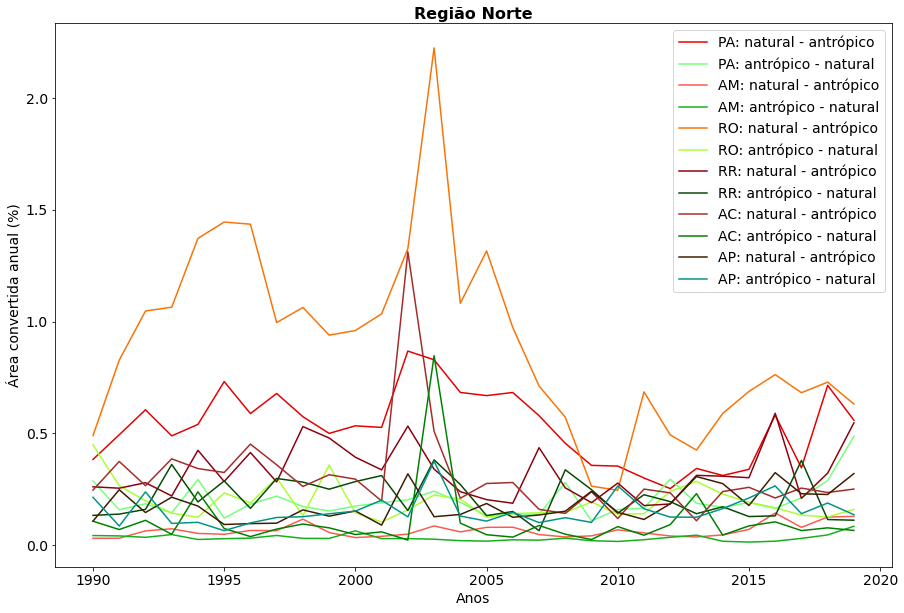

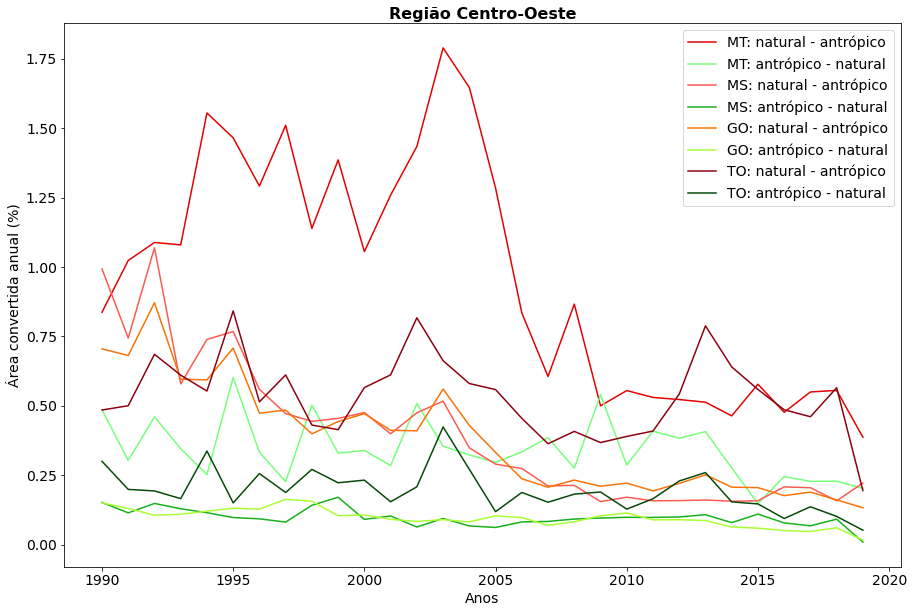

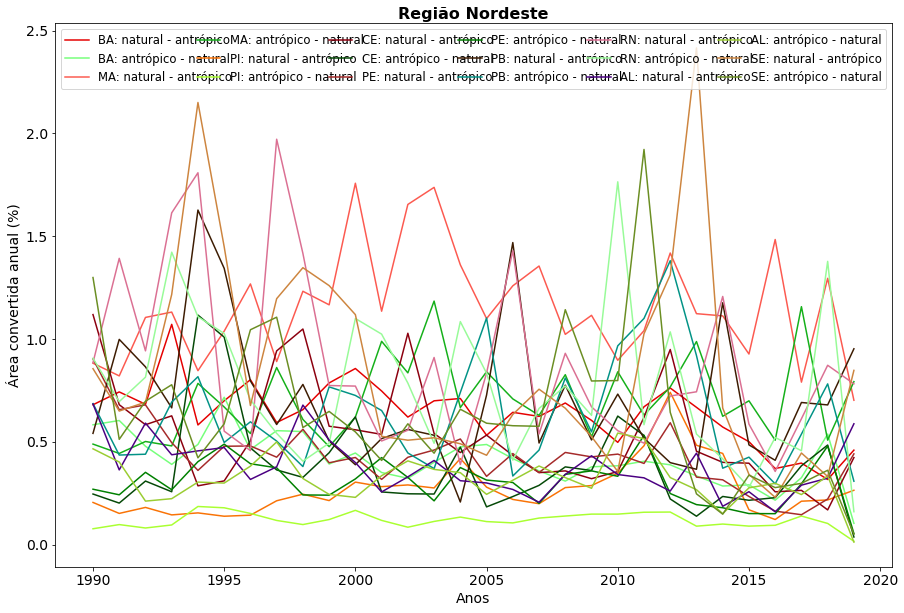

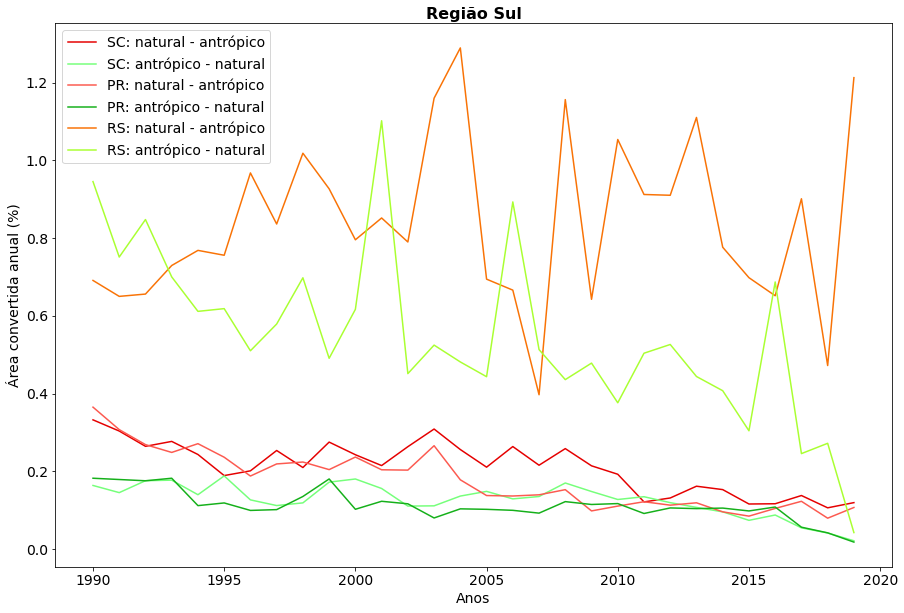

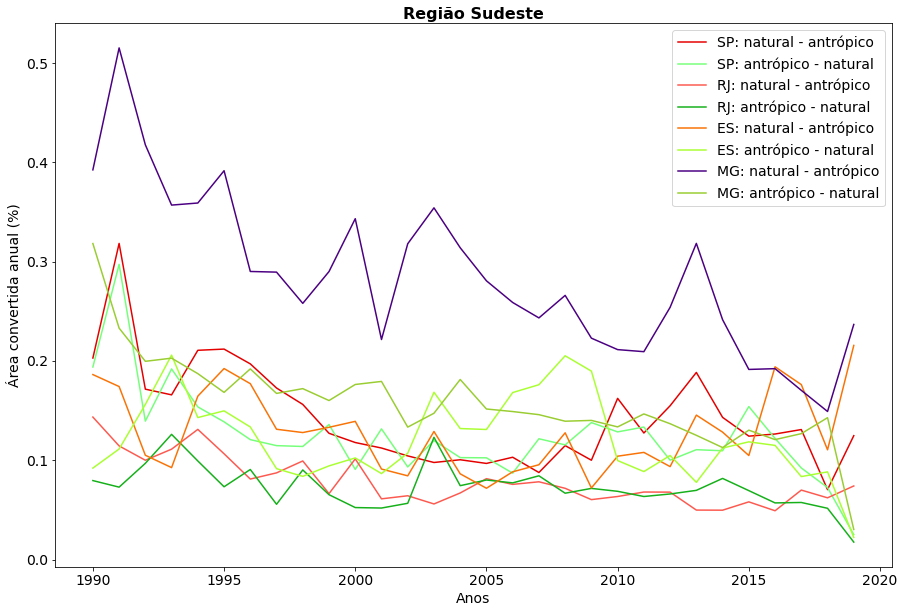

In [18]:
#PLOTANDO SERIES HISTORICAS DE CONVERSAO DE AREA (%da area estadual) ANTROPICA - NATURAL, E VICE VERSA## 
#DADOS POR REGIOES GEOGRAFICAS

#Estados da Regiao Norte (PA, RO, AC, AM, RR, AP)


plt.figure(figsize=(15,10))

plt.plot(df_ntan.loc['PA'].ano, df_ntan.loc['PA'].area1, label='PA: natural - antrópico', color='xkcd:red')
plt.plot(df_annt.loc['PA'].ano, df_annt.loc['PA'].area1, label='PA: antrópico - natural', color='xkcd:lightgreen')

plt.plot(df_ntan.loc['AM'].ano, df_ntan.loc['AM'].area1, label='AM: natural - antrópico', color='xkcd:coral')
plt.plot(df_annt.loc['AM'].ano, df_annt.loc['AM'].area1, label='AM: antrópico - natural', color='xkcd:green')

plt.plot(df_ntan.loc['RO'].ano, df_ntan.loc['RO'].area1, label='RO: natural - antrópico', color='xkcd:orange')
plt.plot(df_annt.loc['RO'].ano, df_annt.loc['RO'].area1, label='RO: antrópico - natural', color='xkcd:lime')         
         
plt.plot(df_ntan.loc['RR'].ano, df_ntan.loc['RR'].area1, label='RR: natural - antrópico', color='xkcd:crimson')
plt.plot(df_annt.loc['RR'].ano, df_annt.loc['RR'].area1, label='RR: antrópico - natural', color='xkcd:darkgreen')        
         
plt.plot(df_ntan.loc['AC'].ano, df_ntan.loc['AC'].area1, label='AC: natural - antrópico', color='brown')
plt.plot(df_annt.loc['AC'].ano, df_annt.loc['AC'].area1, label='AC: antrópico - natural', color='green')  
         
plt.plot(df_ntan.loc['AP'].ano, df_ntan.loc['AP'].area1, label='AP: natural - antrópico', color='xkcd:chocolate')
plt.plot(df_annt.loc['AP'].ano, df_annt.loc['AP'].area1, label='AP: antrópico - natural', color='xkcd:teal')        
plt.legend()


plt.xlabel('Anos')
plt.ylabel('Área convertida anual (%)')

plt.title('Região Norte', fontsize=16, fontweight= 'bold', loc='center', pad=4)



#Estados da Regiao Centro Oeste (MT, MS, GO, TO)


plt.figure(figsize=(15,10))

plt.plot(df_ntan.loc['MT'].ano, df_ntan.loc['MT'].area1, label='MT: natural - antrópico', color='xkcd:red')
plt.plot(df_annt.loc['MT'].ano, df_annt.loc['MT'].area1, label='MT: antrópico - natural', color='xkcd:lightgreen')

plt.plot(df_ntan.loc['MS'].ano, df_ntan.loc['MS'].area1, label='MS: natural - antrópico', color='xkcd:coral')
plt.plot(df_annt.loc['MS'].ano, df_annt.loc['MS'].area1, label='MS: antrópico - natural', color='xkcd:green')

plt.plot(df_ntan.loc['GO'].ano, df_ntan.loc['GO'].area1, label='GO: natural - antrópico', color='xkcd:orange')
plt.plot(df_annt.loc['GO'].ano, df_annt.loc['GO'].area1, label='GO: antrópico - natural', color='xkcd:lime')         
         
plt.plot(df_ntan.loc['TO'].ano, df_ntan.loc['TO'].area1, label='TO: natural - antrópico', color='xkcd:crimson')
plt.plot(df_annt.loc['TO'].ano, df_annt.loc['TO'].area1, label='TO: antrópico - natural', color='xkcd:darkgreen') 

                 
plt.legend()


plt.xlabel('Anos')
plt.ylabel('Área convertida anual (%)')

plt.title('Região Centro-Oeste', fontsize=16, fontweight= 'bold', loc='center', pad=4)



#Estados da Regiao Nordeste (BA, MA, PI, CE, PE, PB, RN, AL, SE)


plt.figure(figsize=(15,10))

plt.plot(df_ntan.loc['BA'].ano, df_ntan.loc['BA'].area1, label='BA: natural - antrópico', color='xkcd:red')
plt.plot(df_annt.loc['BA'].ano, df_annt.loc['BA'].area1, label='BA: antrópico - natural', color='xkcd:lightgreen')

plt.plot(df_ntan.loc['MA'].ano, df_ntan.loc['MA'].area1, label='MA: natural - antrópico', color='xkcd:coral')
plt.plot(df_annt.loc['MA'].ano, df_annt.loc['MA'].area1, label='MA: antrópico - natural', color='xkcd:green')

plt.plot(df_ntan.loc['PI'].ano, df_ntan.loc['PI'].area1, label='PI: natural - antrópico', color='xkcd:orange')
plt.plot(df_annt.loc['PI'].ano, df_annt.loc['PI'].area1, label='PI: antrópico - natural', color='xkcd:lime')         
         
plt.plot(df_ntan.loc['CE'].ano, df_ntan.loc['CE'].area1, label='CE: natural - antrópico', color='xkcd:crimson')
plt.plot(df_annt.loc['CE'].ano, df_annt.loc['CE'].area1, label='CE: antrópico - natural', color='xkcd:darkgreen')        
         
plt.plot(df_ntan.loc['PE'].ano, df_ntan.loc['PE'].area1, label='PE: natural - antrópico', color='brown')
plt.plot(df_annt.loc['PE'].ano, df_annt.loc['PE'].area1, label='PE: antrópico - natural', color='green')  
         
plt.plot(df_ntan.loc['PB'].ano, df_ntan.loc['PB'].area1, label='PB: natural - antrópico', color='xkcd:chocolate')
plt.plot(df_annt.loc['PB'].ano, df_annt.loc['PB'].area1, label='PB: antrópico - natural', color='xkcd:teal')

plt.plot(df_ntan.loc['RN'].ano, df_ntan.loc['RN'].area1, label='RN: natural - antrópico', color='palevioletred')
plt.plot(df_annt.loc['RN'].ano, df_annt.loc['RN'].area1, label='RN: antrópico - natural', color='palegreen')        
         
plt.plot(df_ntan.loc['AL'].ano, df_ntan.loc['AL'].area1, label='AL: natural - antrópico', color='indigo')
plt.plot(df_annt.loc['AL'].ano, df_annt.loc['AL'].area1, label='AL: antrópico - natural', color='yellowgreen')  
         
plt.plot(df_ntan.loc['SE'].ano, df_ntan.loc['SE'].area1, label='SE: natural - antrópico', color='peru')
plt.plot(df_annt.loc['SE'].ano, df_annt.loc['SE'].area1, label='SE: antrópico - natural', color='olivedrab')
plt.legend(loc='upper center', mode='expand', ncol=6, fontsize='small')




plt.xlabel('Anos')
plt.ylabel('Área convertida anual (%)')

plt.title('Região Nordeste', fontsize=16, fontweight= 'bold', loc='center', pad=4)



#Estados da Regiao Sul (RS, PR, SC)


plt.figure(figsize=(15,10))

plt.plot(df_ntan.loc['SC'].ano, df_ntan.loc['SC'].area1, label='SC: natural - antrópico', color='xkcd:red')
plt.plot(df_annt.loc['SC'].ano, df_annt.loc['SC'].area1, label='SC: antrópico - natural', color='xkcd:lightgreen')

plt.plot(df_ntan.loc['PR'].ano, df_ntan.loc['PR'].area1, label='PR: natural - antrópico', color='xkcd:coral')
plt.plot(df_annt.loc['PR'].ano, df_annt.loc['PR'].area1, label='PR: antrópico - natural', color='xkcd:green')

plt.plot(df_ntan.loc['RS'].ano, df_ntan.loc['RS'].area1, label='RS: natural - antrópico', color='xkcd:orange')
plt.plot(df_annt.loc['RS'].ano, df_annt.loc['RS'].area1, label='RS: antrópico - natural', color='xkcd:lime')         


plt.legend()
plt.xlabel('Anos')
plt.ylabel('Área convertida anual (%)')

plt.title('Região Sul', fontsize=16, fontweight= 'bold', loc='center', pad=4)


#Estados da Regiao Sudeste (SP, RJ, MG, ES)


plt.figure(figsize=(15,10))

plt.plot(df_ntan.loc['SP'].ano, df_ntan.loc['SP'].area1, label='SP: natural - antrópico', color='xkcd:red')
plt.plot(df_annt.loc['SP'].ano, df_annt.loc['SP'].area1, label='SP: antrópico - natural', color='xkcd:lightgreen')

plt.plot(df_ntan.loc['RJ'].ano, df_ntan.loc['RJ'].area1, label='RJ: natural - antrópico', color='xkcd:coral')
plt.plot(df_annt.loc['RJ'].ano, df_annt.loc['RJ'].area1, label='RJ: antrópico - natural', color='xkcd:green')

plt.plot(df_ntan.loc['ES'].ano, df_ntan.loc['ES'].area1, label='ES: natural - antrópico', color='xkcd:orange')
plt.plot(df_annt.loc['ES'].ano, df_annt.loc['ES'].area1, label='ES: antrópico - natural', color='xkcd:lime')         

plt.plot(df_ntan.loc['MG'].ano, df_ntan.loc['MG'].area1, label='MG: natural - antrópico', color='indigo')
plt.plot(df_annt.loc['MG'].ano, df_annt.loc['MG'].area1, label='MG: antrópico - natural', color='yellowgreen')

plt.legend()
plt.xlabel('Anos')
plt.ylabel('Área convertida anual (%)')

plt.title('Região Sudeste', fontsize=16, fontweight= 'bold', loc='center', pad=4)

In [19]:

#Agrupando os dados de conversao entre decadas e de acordo com o sentido antropico -> natural (desmatamento)
# ou natural -> antropico (regeneracao)

# Entre 1990-2000

df_annt_90_00 = df_annt.loc[df_annt['ano'] < 2001][['area', 'area1']].groupby('sigla_uf').sum()
df_annt_90_00['decada'] = '1991-2000'
df_ntan_90_00 = df_ntan.loc[df_ntan['ano'] < 2001][['area', 'area1']].groupby('sigla_uf').sum()
df_90_00 = df_annt_90_00.merge(df_ntan_90_00, on='sigla_uf')

df_90_00.rename(columns = {'area_x':'area_ANNT', 'area1_x':'area1_ANNT', 'area_y':'area_NTAN', 'area1_y':'area1_NTAN'}, inplace = True)

# Entre 2001-2010

df_annt_00_10 = df_annt.loc[(df_annt['ano'] > 2000) & (df_annt['ano'] < 2011)][['area', 'area1']].groupby('sigla_uf').sum()
df_annt_00_10['decada'] = '2001-2010'
df_ntan_00_10 = df_ntan.loc[(df_ntan['ano'] > 2000) & (df_ntan['ano'] < 2011)][['area', 'area1']].groupby('sigla_uf').sum()
df_00_10 = df_annt_00_10.merge(df_ntan_00_10, on='sigla_uf')

df_00_10.rename(columns = {'area_x':'area_ANNT', 'area1_x':'area1_ANNT', 'area_y':'area_NTAN', 'area1_y':'area1_NTAN'}, inplace = True)

# Entre 2011-2015

df_annt_11_15 = df_annt.loc[(df_annt['ano'] > 2010) & (df_annt['ano'] < 2016)][['area', 'area1']].groupby('sigla_uf').sum()
df_annt_11_15['decada'] = '2011-2015'
df_ntan_11_15 = df_ntan.loc[(df_ntan['ano'] > 2010) & (df_ntan['ano'] < 2016)][['area', 'area1']].groupby('sigla_uf').sum()
df_11_15 = df_annt_11_15.merge(df_ntan_11_15, on='sigla_uf')

df_11_15.rename(columns = {'area_x':'area_ANNT', 'area1_x':'area1_ANNT', 'area_y':'area_NTAN', 'area1_y':'area1_NTAN'}, inplace = True)


# Entre 2016-2019

df_annt_15_20 = df_annt.loc[(df_annt['ano'] > 2015) & (df_annt['ano'] < 2021)][['area', 'area1']].groupby('sigla_uf').sum()
df_annt_15_20['decada'] = '2016-2019'
df_ntan_15_20 = df_ntan.loc[(df_ntan['ano'] > 2015) & (df_ntan['ano'] < 2021)][['area', 'area1']].groupby('sigla_uf').sum()
df_15_20 = df_annt_15_20.merge(df_ntan_15_20, on='sigla_uf')

df_15_20.rename(columns = {'area_x':'area_ANNT', 'area1_x':'area1_ANNT', 'area_y':'area_NTAN', 'area1_y':'area1_NTAN'}, inplace = True)


#Agrupando todas as colunas num df acumulado por década

df_acum3 = df_90_00.append(df_00_10).append(df_11_15).append(df_15_20)



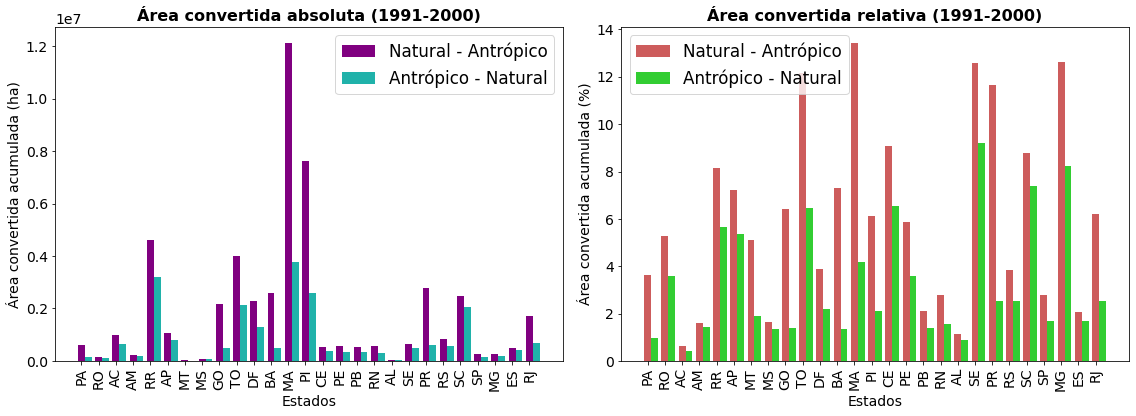

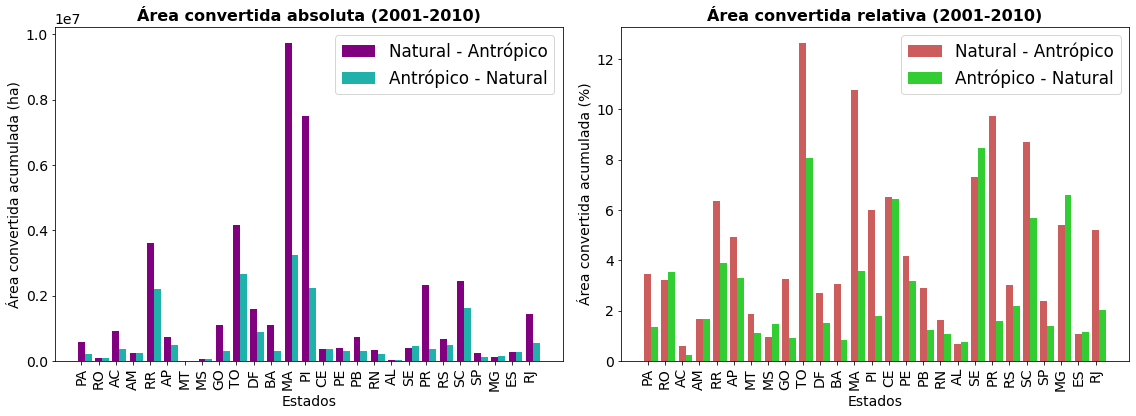

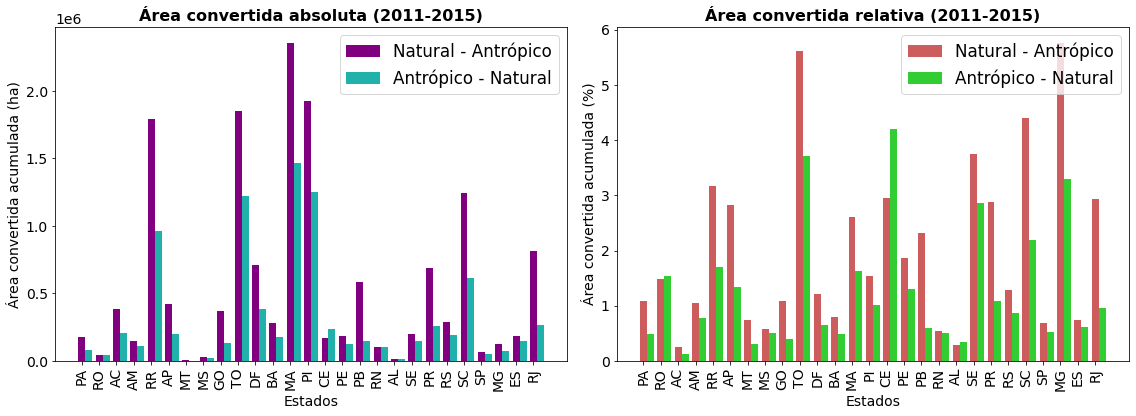

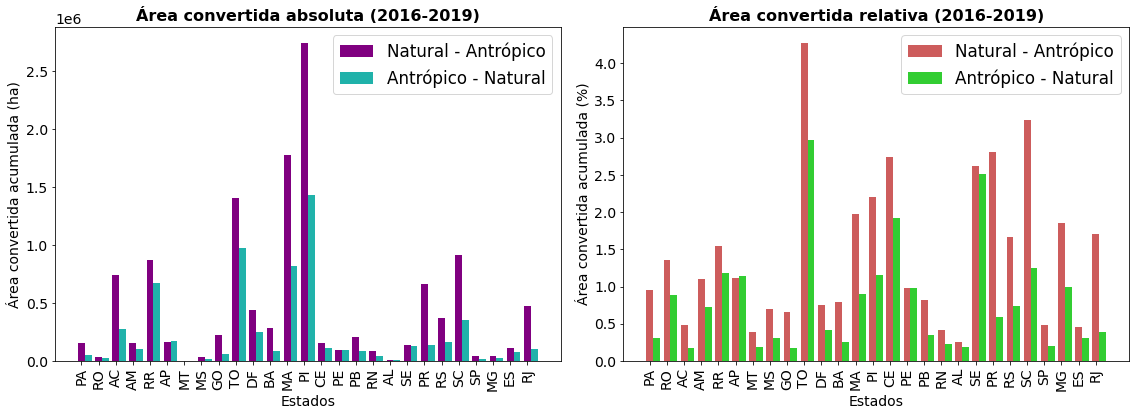

In [20]:
#Plotando graficos de barras, com os dados absolutos e relativos, lado a lado

#Essa alça faz uso do dicionário com areas dos estados, assim como
#da lista criada a partir do dataframe gerado com as siglas dos estados

for ano in df_acum3['decada'].unique():
  fig, ax = plt.subplots(1,2, figsize=(16, 6))
  x_axis = (np.arange(len(estados))*2)
  x = df_acum3.loc[df_acum3['decada'] == ano]


  ax[0].bar(x_axis -0.4, x.area_NTAN, width=0.8, align='edge',
            label = 'Natural - Antrópico', color= 'purple')
  ax[0].bar(x_axis +0.4, x.area_ANNT, width=0.8, align='edge',
            label = 'Antrópico - Natural', color= 'lightseagreen')

  ax[0].set_xlabel("Estados", fontdict={'fontsize': 14})
  ax[0].set_ylabel('Área convertida acumulada (ha)', fontdict={'fontsize': 14})
  ax[0].set_title(f"Área convertida absoluta ({ano})", fontdict={'fontsize': 16, 'fontweight':'semibold'})

  ax[0].set_xticks(x_axis)
  ax[0].set_xticklabels(estados, rotation=90, fontdict={'fontsize': 14})
  ax[0].legend(fontsize= 'large')

  ax[1].bar(x_axis -0.4, x.area1_NTAN,width=0.8, align='edge', 
            label = 'Natural - Antrópico', color= 'indianred')
  ax[1].bar(x_axis +0.4, x.area1_ANNT, width=0.8, align='edge',
            label = 'Antrópico - Natural', color= 'limegreen')
  ax[1].set_xlabel("Estados", fontdict={'fontsize': 14})
  ax[1].set_ylabel('Área convertida acumulada (%)', fontdict={'fontsize': 14})
  ax[1].set_title(f"Área convertida relativa ({ano})", fontdict={'fontsize': 16, 'fontweight':'semibold'})


  ax[1].set_xticks(x_axis)
  ax[1].set_xticklabels(estados, rotation=90, fontdict={'fontsize': 14})
  ax[1].legend(fontsize= 'large')



  plt.tight_layout()
  plt.show()


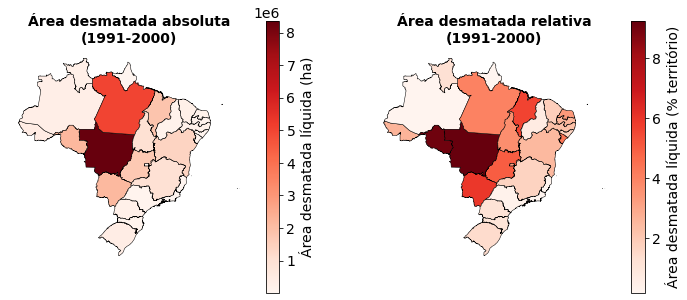

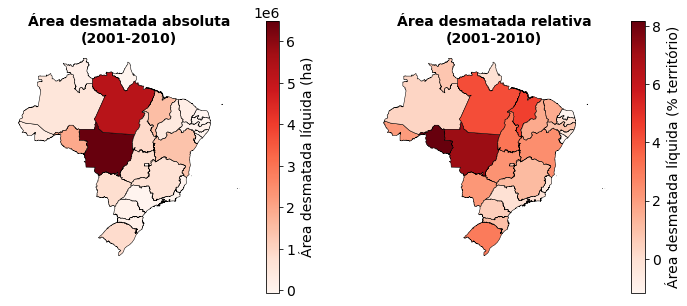

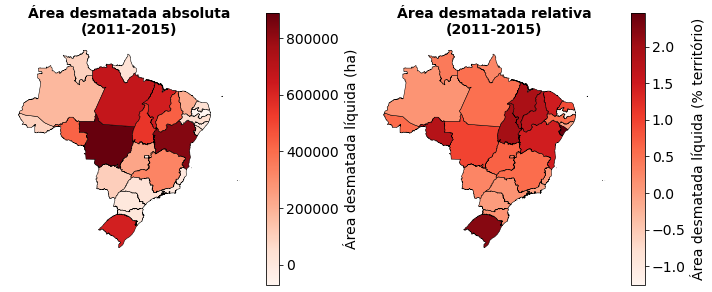

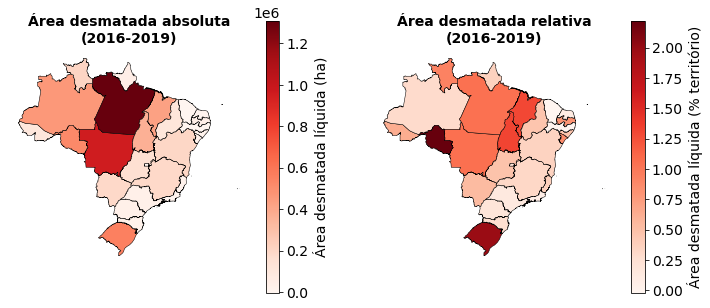

In [21]:
##PLOTANDO MAPAS DE DESMATAMENTO LIQUIDO POR DECADA##


#Primeiro, cria-se colunas com dados de desmatamento líquido, i.e.
#desmatamento (natural->antrópico) substraído da regeneração (anóptrico->natural)

df_acum3['area_liq_abs'] = df_acum3['area_NTAN'] - df_acum3['area_ANNT']
df_acum3['area_liq_rel'] = df_acum3['area1_NTAN'] - df_acum3['area1_ANNT']

#Crio um novo dataframe sem as colunas anteriores
df_acum4 = df_acum3.drop(
    columns=['area_ANNT', 'area1_ANNT', 'area_NTAN', 'area1_NTAN'])


gdf_acum4 = df_acum4.merge(gdf_estados, on='sigla_uf').drop(
    columns=['CD_UF', 'NM_REGIAO', 'NM_UF'])

gdf_acum4 = GeoDataFrame(gdf_acum4)

#Essa alça faz uso do dicionário de estados com suas áreas, assim como
#a lista com suas siglas criada a partir dele

for ano in gdf_acum4['decada'].unique():
  fig, ax = plt.subplots(1, 2, figsize=[12, 5])
  x = gdf_acum4.loc[gdf_acum4['decada'] == ano]
  x.set_index('sigla_uf', inplace=True)

  x.plot(column='area_liq_abs', edgecolor="black", cmap='Reds',
         ax=ax[0], legend=True,linewidth=0.5,
         legend_kwds={'label': "Área desmatada líquida (ha)"})
  ax[0].set_axis_off()
  ax[0].set_title(f'Área desmatada absoluta\n({ano})', fontdict={'fontsize': 14,
                                                                    'fontweight' : 'semibold'})
  
  x.plot(column='area_liq_rel', edgecolor="black", cmap='Reds',
         ax=ax[1], legend=True, linewidth=0.5, 
         legend_kwds={'label': "Área desmatada líquida (% território)"})
  ax[1].set_axis_off()
  ax[1].set_title(f'Área desmatada relativa\n({ano})', fontdict={'fontsize': 14,
 'fontweight' : 'semibold'})
  
  plt.show()



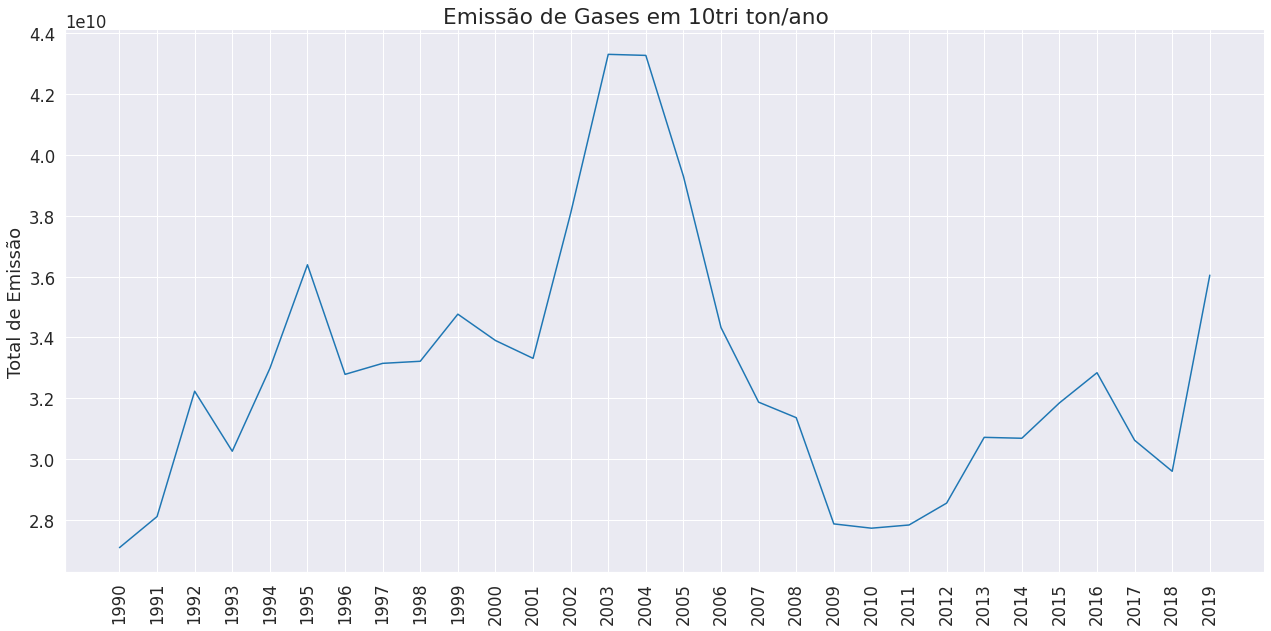

In [22]:
url='https://drive.google.com/file/d/1nhUlPh8P9db9-T1u3mVkcfonFfywEd2I/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
# Estabeleça o período a ser estudado
anos = [str(x) for x in range(1990,2020)]

# Calcule a emissão total para cada ano do período.
df[anos] = df[anos].apply(pd.to_numeric, errors='coerce', axis=1)
df.loc['Column_Total']= df.sum(numeric_only=True, axis=0)

# Crie o DataFrame com os totais por ano.
data={'anos':anos,'total':df[anos].sum()}
data=pd.DataFrame(data)

# Projete o DataFrame.
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.5)
g = sns.relplot(data=data, kind='line', x='anos', y='total', height = 9, aspect = 2)
plt.xlabel('')
plt.ylabel('Total de Emissão')
g.fig.suptitle('Emissão de Gases em 10tri ton/ano', fontdict = {'fontsize': 14})
plt.xticks(rotation=90)
plt.show()

In [23]:
# Crie uma lista com todos os estados brasileiros.
url='https://drive.google.com/file/d/1CVykXVGps1TKwSibhUKqdhUMFusW3vfQ/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

estados_dict = {}
i = 0
""" Mais uma vez, atente-se ao pathway da importação! """
for chunk in pd.read_csv(url, chunksize=1000):
    for entry in chunk['Estado'].dropna():
        if entry not in estados_dict.keys():
            estados_dict[entry] = i
            i += 1
estados_list = list(estados_dict.keys())
print(estados_list)

['SP', 'BA', 'RJ', 'MG', 'SE', 'PR', 'RO', 'AM', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'MT', 'MS', 'GO', 'DF', 'ES', 'SC', 'RS', 'AC', 'AP', 'RR']


In [25]:
# faça o somatório das emissões, porém com loop para todos os anos.
totais_estaduais = {}
for est in estados_list:
    estado=[]
    for ano in anos:
        u = df.loc[df['Estado'] == est, ano].sum(axis=0)
        estado.append(u)
    totais_estaduais[est]=estado
totais_estaduais = pd.DataFrame(totais_estaduais)

# Para fins de verificação, olhe ao resumo do DataFrame gerado.
print(totais_estaduais.head())

             SP            BA            RJ            MG           SE  \
0  6.090146e+08  7.018007e+08  1.746398e+08  8.597506e+08  66267271.66   
1  6.704564e+08  7.180667e+08  1.811555e+08  1.015898e+09  42178940.45   
2  6.124636e+08  5.989151e+08  1.812632e+08  9.324052e+08  45288355.88   
3  6.381794e+08  6.484479e+08  1.856953e+08  9.424913e+08  38039849.06   
4  7.188461e+08  5.884737e+08  1.953815e+08  8.732659e+08  39419117.95   

             PR            RO            AM            PA            TO  ...  \
0  4.283072e+08  5.593785e+08  3.143864e+08  2.212638e+09  3.430726e+08  ...   
1  3.859111e+08  8.023402e+08  3.171304e+08  2.512832e+09  3.246447e+08  ...   
2  3.550699e+08  1.124123e+09  4.550338e+08  3.126249e+09  4.124489e+08  ...   
3  3.856194e+08  1.092569e+09  5.046551e+08  2.537967e+09  3.654126e+08  ...   
4  4.004264e+08  1.358759e+09  4.616890e+08  3.011209e+09  3.139537e+08  ...   

             MT            MS            GO           DF            ES  \


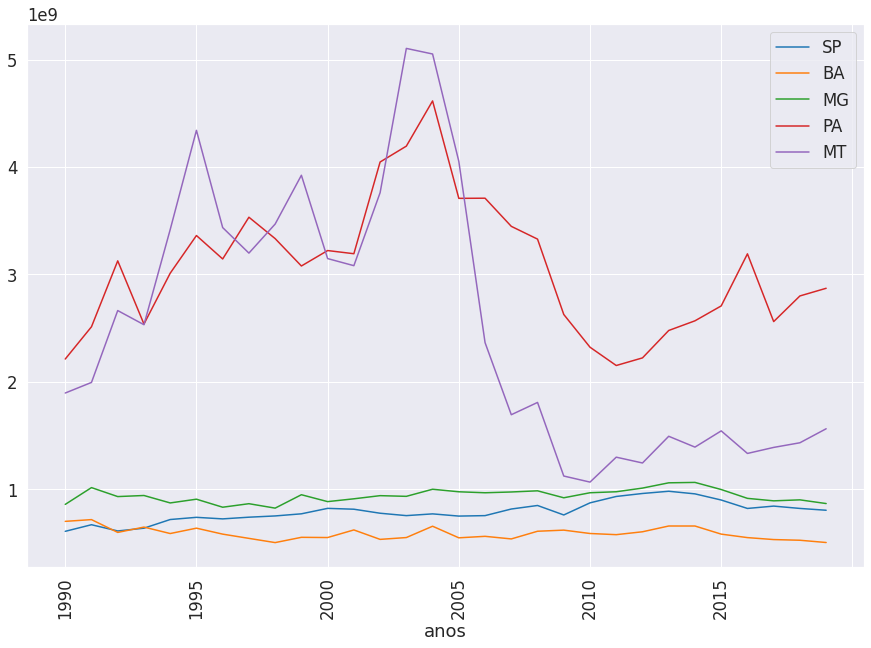

In [27]:
# Adicione a coluna 'anos' ao DataFrame para que estes apareçam no gráfico resultante.
totais_estaduais['anos'] = anos
totais_estaduais.plot(x = 'anos', y = [estados_list[0],estados_list[1],estados_list[3],
                                       estados_list[8],estados_list[17]], kind = 'line', figsize=(15,10))
# Configure as condições para embelezar o gráfico
g.fig.suptitle('Emissão de Gases em 10tri ton/ano')
plt.xticks(rotation=90)

""" Caso queira usar todos os estados, ative a próxima linha. """
#plt.legend(bbox_to_anchor = (1.05,1), title = 'estados')

plt.show()

['N2O (t)', 'CO (t)', 'NOx (t)', 'CO2 (t)', 'CH4 (t)']
Diga um ano entre 1990-2019.  2016


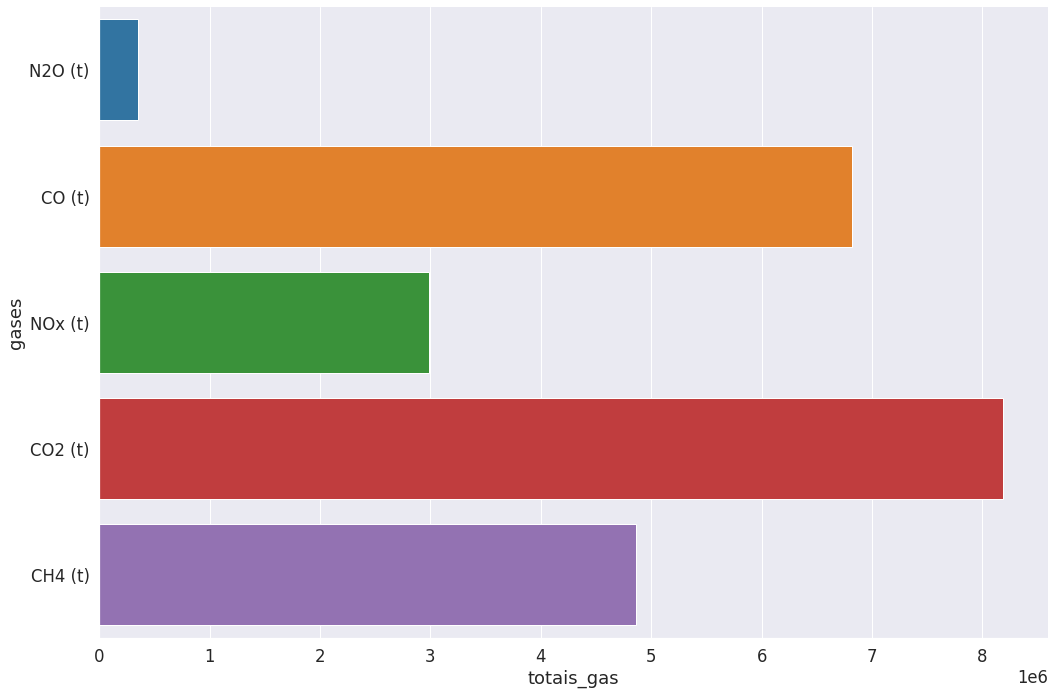

<Figure size 1440x720 with 0 Axes>

In [41]:
# Faça o mesmo processo feito com os estados, mas agora filtrando para cada gás emitido.
gases_dict = {}
i = 0
for chunk in pd.read_csv(url, chunksize=1000):
    for entry in chunk['Gás'].dropna():
        if entry not in gases_dict.keys():
            gases_dict[entry] = i
            i += 1
gases_list = list(gases_dict.keys())

# Selecione os gases mais importantes para análise, evitando que a visualização fique *poluída*.
gases_list = [gases_list[1],gases_list[2],gases_list[3],gases_list[6],gases_list[7]]
print(gases_list)

# Pergunte ao usuário em qual ano ele gostaria de fazer a análise.
while True:
    ano_esc = input('Diga um ano entre 1990-2019.  ')
    if ano_esc in anos:
        break

# Como o CO2 é (consideravelmente) mais emitido, colocaremos as emissões de CO2 divididas por 250, prezando a visualização
# dos dados.
totais_gas = []
for gas in gases_list:
    if gas == 'CO2 (t)':
        u = df.loc[df['Gás'] == 'CO2 (t)', ano_esc].sum(axis=0)/250
        totais_gas.append(u)
    else:
        u = df.loc[df['Gás'] == gas, ano_esc].sum(axis=0)
        totais_gas.append(u)
dados_gas = {'gases':gases_list, 'totais_gas':totais_gas}
dados_gas = pd.DataFrame(dados_gas)

# Projete o DataFrame.
sns.catplot(data=dados_gas,kind='bar',x='totais_gas',y='gases', height = 10, aspect = 1.5)
plt.figure(figsize=(20,10))
plt.show()

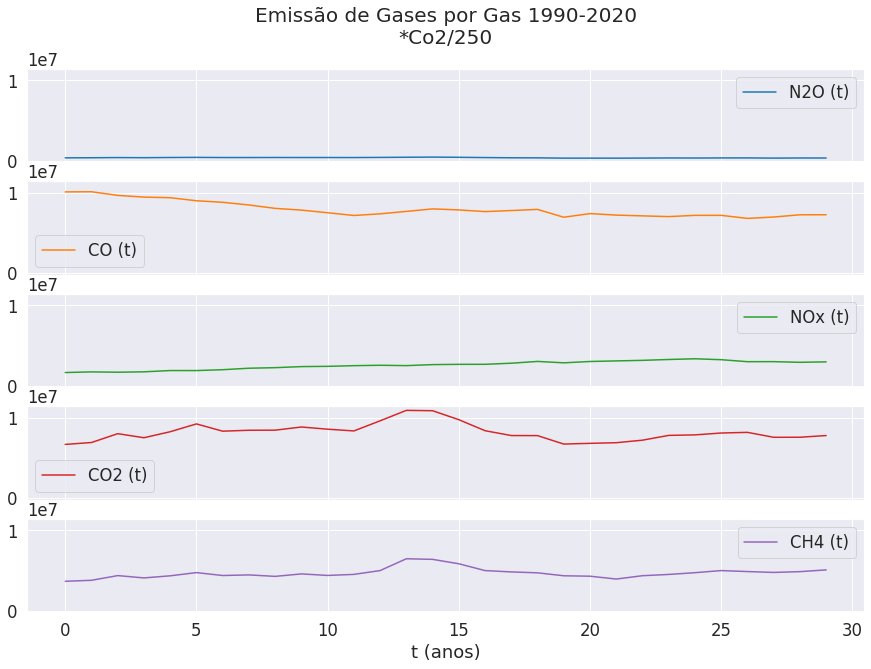

In [47]:
# Repita o processo com um loop para todos os anos.
totais_gases = {}
for gas in gases_list:
    gas_cont = []
    if gas == 'CO2 (t)':
        for ano in anos:
            u = df.loc[df['Gás'] == 'CO2 (t)', ano].sum(axis=0)/250
            gas_cont.append(u)
    else:
        for ano in anos:
            u = df.loc[df['Gás'] == gas, ano].sum(axis=0)
            gas_cont.append(u)
    totais_gases[gas] = gas_cont
totais_gases = pd.DataFrame(totais_gases)

# Projete os gráficos de cada gás paralelamente, de modo a comparar as variações anuais.
totais_gases.plot(subplots=True, figsize=(15, 10), sharey=True)
plt.title('Emissão de Gases por Gas 1990-2020\n*Co2/250', y=6, fontsize = 20)
plt.xlabel('t (anos)')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


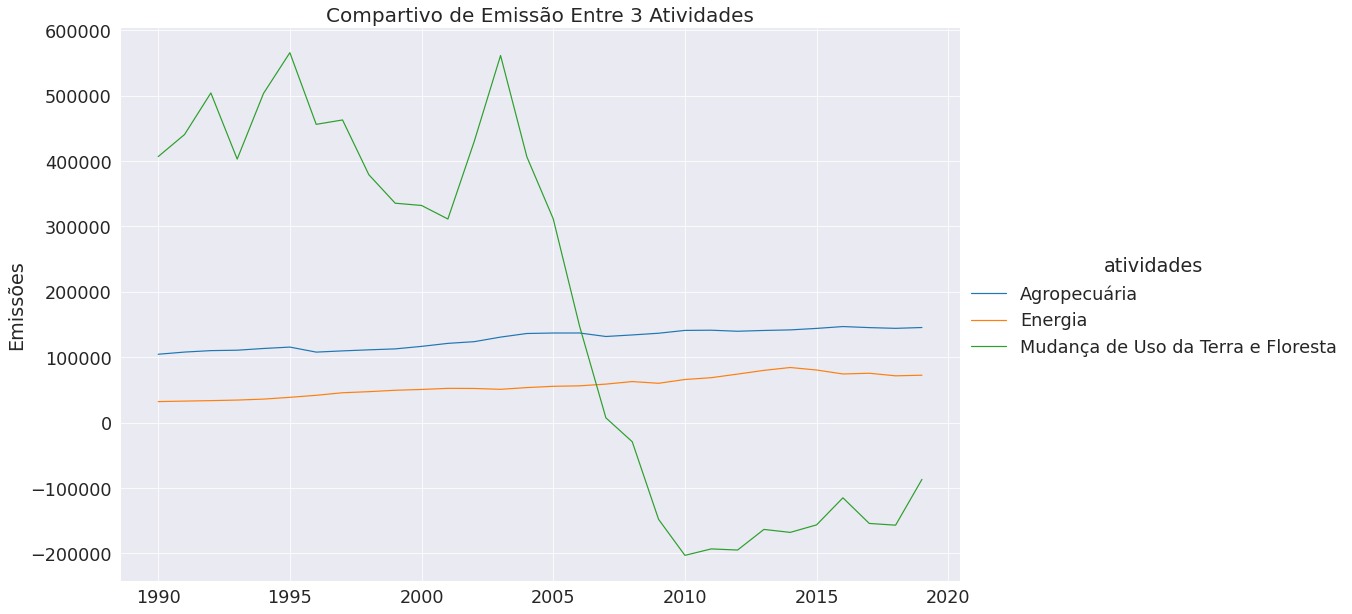

In [49]:
ativi_emissoes = gases_est
ativi_emissoes= ativi_emissoes[ativi_emissoes['nivel_1'].isin(['Agropecuária', 'Mudança de Uso da Terra e Floresta', 'Energia'])]
ativi_emissoes.rename(columns={'nivel_1': 'atividades'}, inplace = True)
ativi_emissoes = ativi_emissoes.loc[(ativi_emissoes['ano'] > 1989) & (ativi_emissoes['ano'] < 2020)]
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.relplot(x="ano", y="emissao", data=ativi_emissoes, ci=None, kind="line", hue='atividades', height = 9, aspect = 1.6)
plt.title('Compartivo de Emissão Entre 3 Atividades', fontsize = 20)
plt.xlabel('')
plt.ylabel('Emissões')
plt.show()

In [50]:
taxas_emissoes = gases_est
taxas_emissoes.rename(columns={'nivel_1': 'atividades'}, inplace = True)
## PARA UMA ANÁLISE MAIS ESPECÍFICA, DEVE-SE RESTRINGIR OS DADOS PARA AS ATIVIDADES QUE EFETIVAMENTE ALTERARAM O USO DA TERRA
taxas_emissoes = taxas_emissoes[taxas_emissoes['atividades'].isin(['Agropecuária', 'Mudança de Uso da Terra e Floresta'])]
## COMO HÁ POUCOS DADOS FALTANTES, NÃO SE ALTERA A ANÁLISE DOS DADOS SE ELES FOREM RETIRADOS
taxas_emissoes = taxas_emissoes.dropna(subset=["emissao"])
## COMO OS DADOS ANTES DOS ANOS 90 SÃO INCIPIENTES, DEVE-SE CONSIDERAR APENAS OS DADOS A PARTIR DO ANOS 90. ALÉM DISSO, NO ANO DE 2020, PRINCIPALMENTE POR CONTA DA PANDEMIA, 
## OS DADOS SÃO DISTINTOS DOS ANTERIORES, ENTÃO OPTOU-SE POR DESCONSIDERÁ-LOS
taxas_emissoes = taxas_emissoes.loc[(taxas_emissoes['ano'] > 1989) & (taxas_emissoes['ano'] < 2020)]
taxas_emissoes.tail()

,ano,sigla_uf,atividades,nivel_2,nivel_3,nivel_4,nivel_5,nivel_6,tipo_emissao,gas,atividade_economica,produto,emissao
3276628,2019,TO,Mudança de Uso da Terra e Floresta,Resíduos Florestais,Cerrado,NÃO SE APLICA,NÃO SE APLICA,NÃO SE APLICA,Emissão,CO2e (t) GTP-AR5,AGROPEC,NÃO SE APLICA,125938.0
3276629,2019,TO,Mudança de Uso da Terra e Floresta,Resíduos Florestais,Cerrado,NÃO SE APLICA,NÃO SE APLICA,NÃO SE APLICA,Emissão,CO2e (t) GWP-AR2,AGROPEC,NÃO SE APLICA,325922.0
3276630,2019,TO,Mudança de Uso da Terra e Floresta,Resíduos Florestais,Cerrado,NÃO SE APLICA,NÃO SE APLICA,NÃO SE APLICA,Emissão,CO2e (t) GWP-AR4,AGROPEC,NÃO SE APLICA,362070.0
3276631,2019,TO,Mudança de Uso da Terra e Floresta,Resíduos Florestais,Cerrado,NÃO SE APLICA,NÃO SE APLICA,NÃO SE APLICA,Emissão,CO2e (t) GWP-AR5,AGROPEC,NÃO SE APLICA,380421.0
3276632,2019,TO,Mudança de Uso da Terra e Floresta,Resíduos Florestais,Cerrado,NÃO SE APLICA,NÃO SE APLICA,NÃO SE APLICA,Emissão,N2O (t),AGROPEC,NÃO SE APLICA,365.0


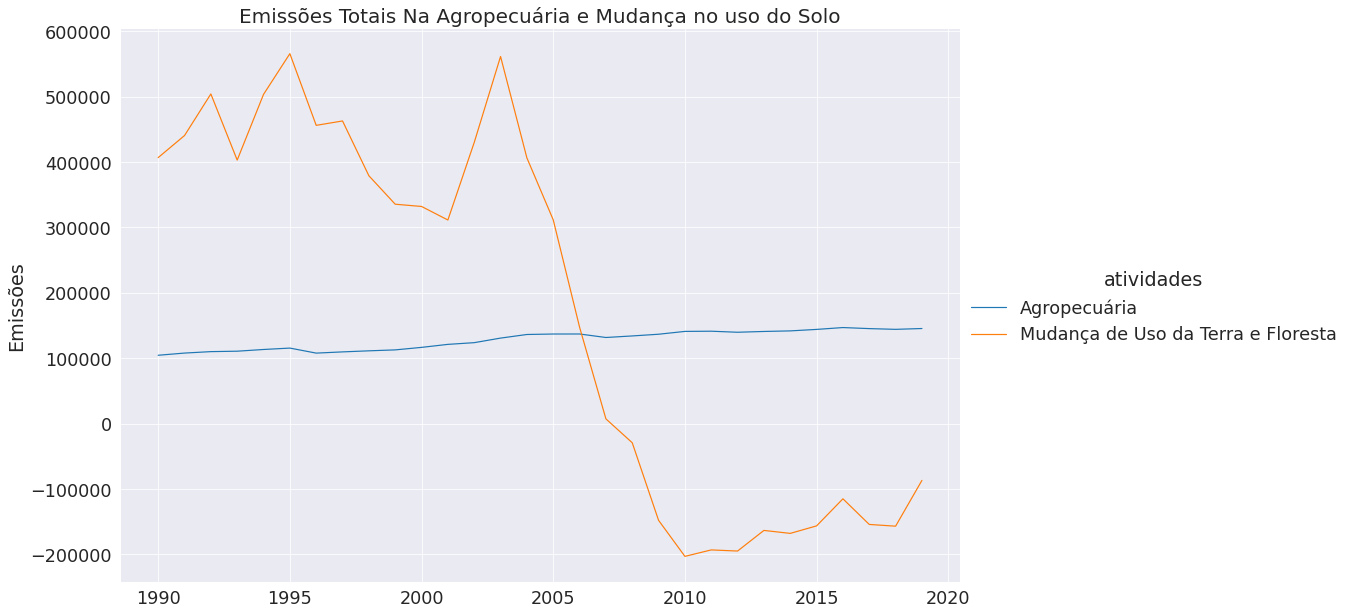

In [53]:
## COMPARANDO A EMISSÃO GERAL, DISCRIMINANDO ENTRE AGROPECUÁRIA E MUDANÇA NO USO DO SOLO
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.relplot(x="ano", y="emissao", data=taxas_emissoes, ci=None, kind="line", hue='atividades', height = 9, aspect = 1.6)
plt.title("Emissões Totais Na Agropecuária e Mudança no uso do Solo", fontsize=20)
plt.xlabel('')
plt.ylabel('Emissões')
plt.show()


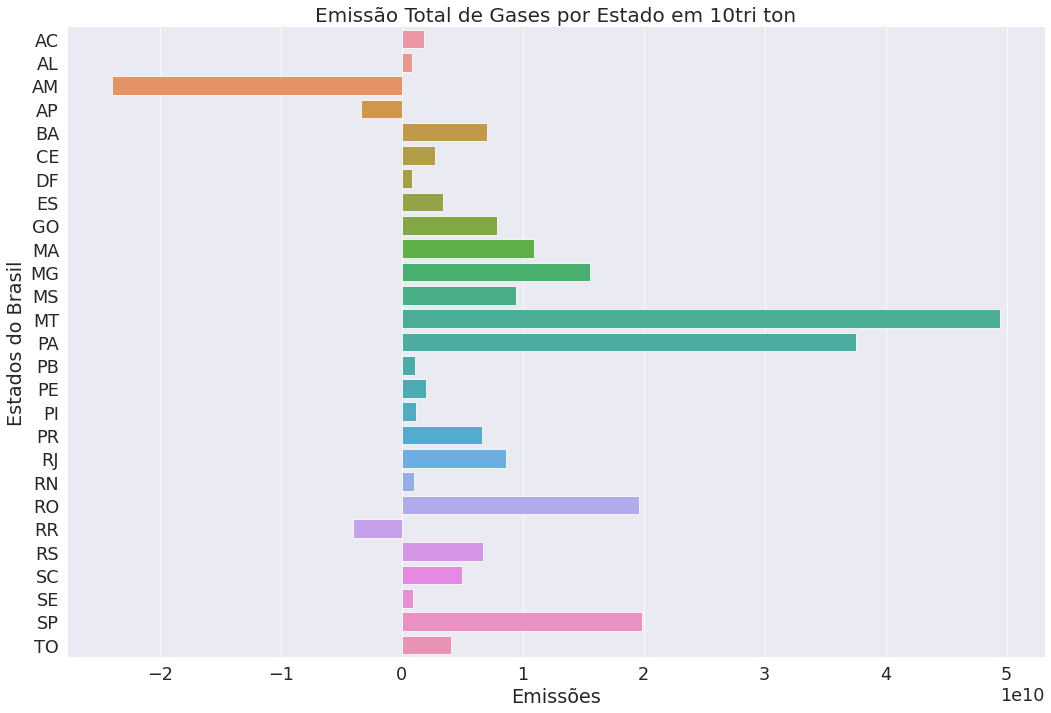

In [65]:
## COMO QUEREMOS SOMAR AS EMISSOES DE CADA ESTADOS, UTILIZAMOS O MÉTODO GROUPBY, PASSANDO UM DICIONÁRIO COM A FUNÇÃO 'SUM' NA COLUNA 'EMISSAO'
soma_emissao = gases_est
soma_emissao = soma_emissao.loc[(soma_emissao['ano'] > 1989) & (soma_emissao['ano'] < 2020)]
soma_emissao = soma_emissao.groupby('sigla_uf').agg({'emissao':'sum'})
## APÓS A OPERAÇÃO, O INDEX FICOU DEFINIDO COMO 'SIGLA_UF', MAS DEVE-SE VOLTAR O INDEX AO ORIGINAL
soma_emissao = soma_emissao.reset_index()
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.catplot(data=soma_emissao,kind='bar',x='emissao',y='sigla_uf', height = 10, aspect = 1.5)
plt.title('Emissão Total de Gases por Estado em 10tri ton', y=1, fontsize = 20)
plt.ylabel('Estados do Brasil')
plt.xlabel('Emissões')
plt.show()

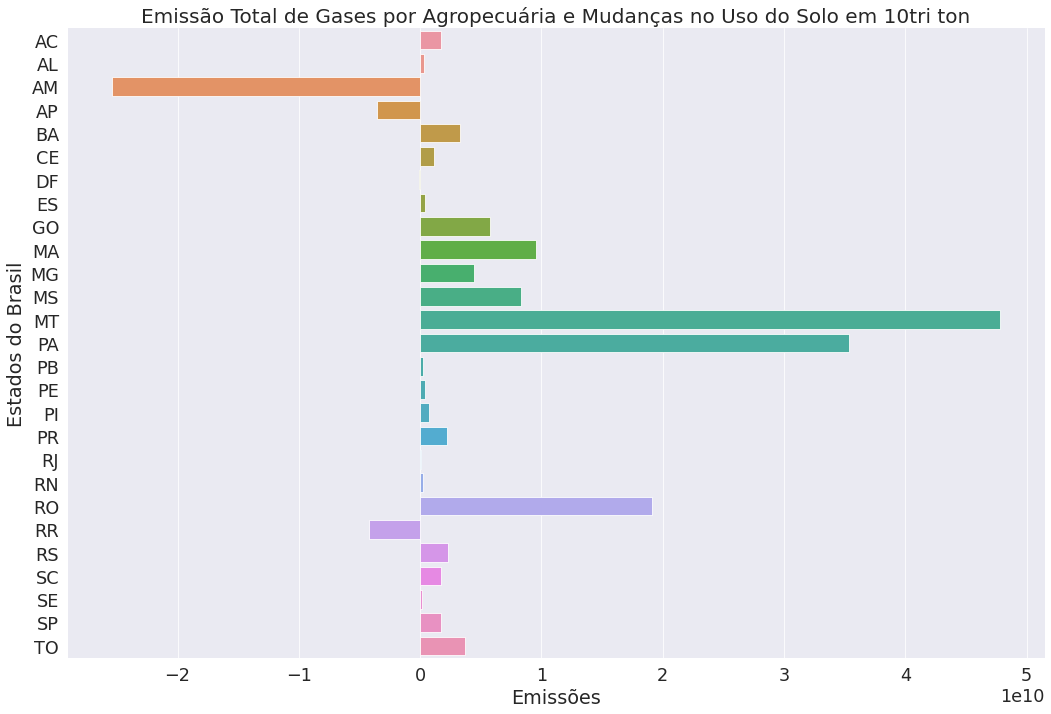

In [66]:
## COMO QUEREMOS SOMAR AS EMISSOES DE CADA ESTADOS, UTILIZAMOS O MÉTODO GROUPBY, PASSANDO UM DICIONÁRIO COM A FUNÇÃO 'SUM' NA COLUNA 'EMISSAO'
soma_emissao_2 = taxas_emissoes.groupby('sigla_uf').agg({'emissao':'sum'})
## APÓS A OPERAÇÃO, O INDEX FICOU DEFINIDO COMO 'SIGLA_UF', MAS DEVE-SE VOLTAR O INDEX AO ORIGINAL
soma_emissao_2 = soma_emissao_2.reset_index()
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.catplot(data=soma_emissao_2,kind='bar',x='emissao',y='sigla_uf', height = 10, aspect = 1.5)
plt.title('Emissão Total de Gases por Agropecuária e Mudanças no Uso do Solo em 10tri ton', y=1, fontsize = 20)
plt.ylabel('Estados do Brasil')
plt.xlabel('Emissões')
plt.show()

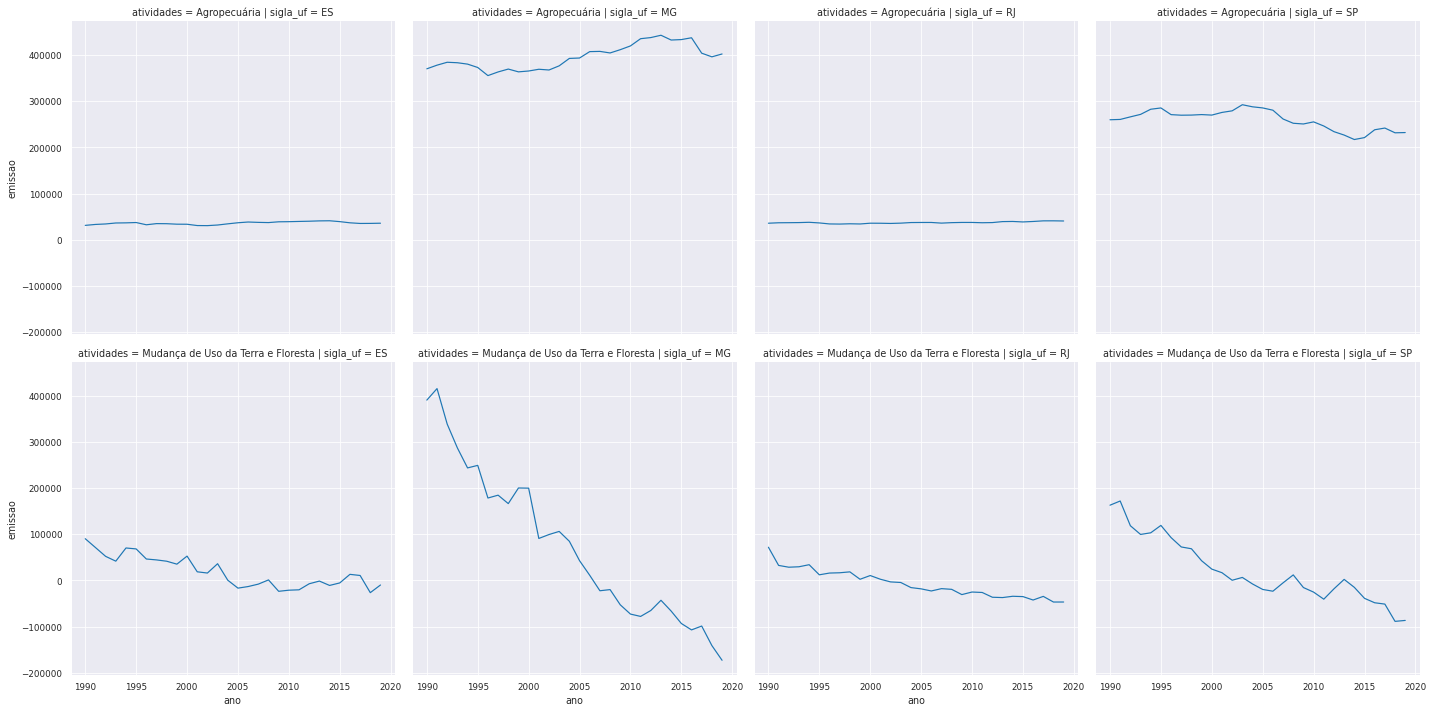

In [ ]:
## SEPARANDO OS DADOS PELOS ESTADOS QUE ESTÃO NO SUDESTE
emissao_sudeste = taxas_emissoes[taxas_emissoes['sigla_uf'].isin(['SP', 'RJ', 'MG', 'ES'])]
sns.set_style("darkgrid")
sns.set_context('paper')
sns.relplot(x="ano", y="emissao", data=emissao_sudeste, ci=None, kind="line", col='sigla_uf', row='atividades')
plt.xlabel('')
plt.ylabel('Emissões')
plt.show()

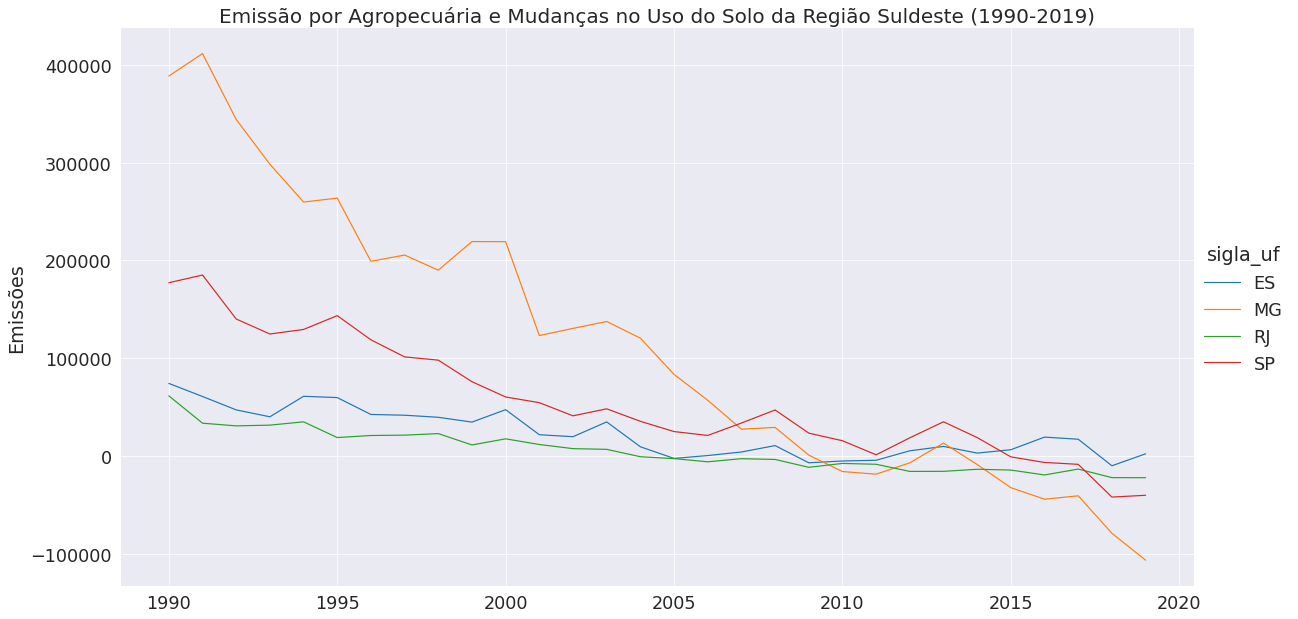

In [67]:
emissao_sudeste = taxas_emissoes[taxas_emissoes['sigla_uf'].isin(['SP', 'RJ', 'MG', 'ES'])]
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.relplot(x="ano", y="emissao", data=emissao_sudeste, ci=None, kind="line", hue ="sigla_uf", height = 9, aspect = 1.9)
plt.title('Emissão por Agropecuária e Mudanças no Uso do Solo da Região Suldeste (1990-2019)', y=1, fontsize = 20)
plt.xlabel('')
plt.ylabel('Emissões')
plt.show()

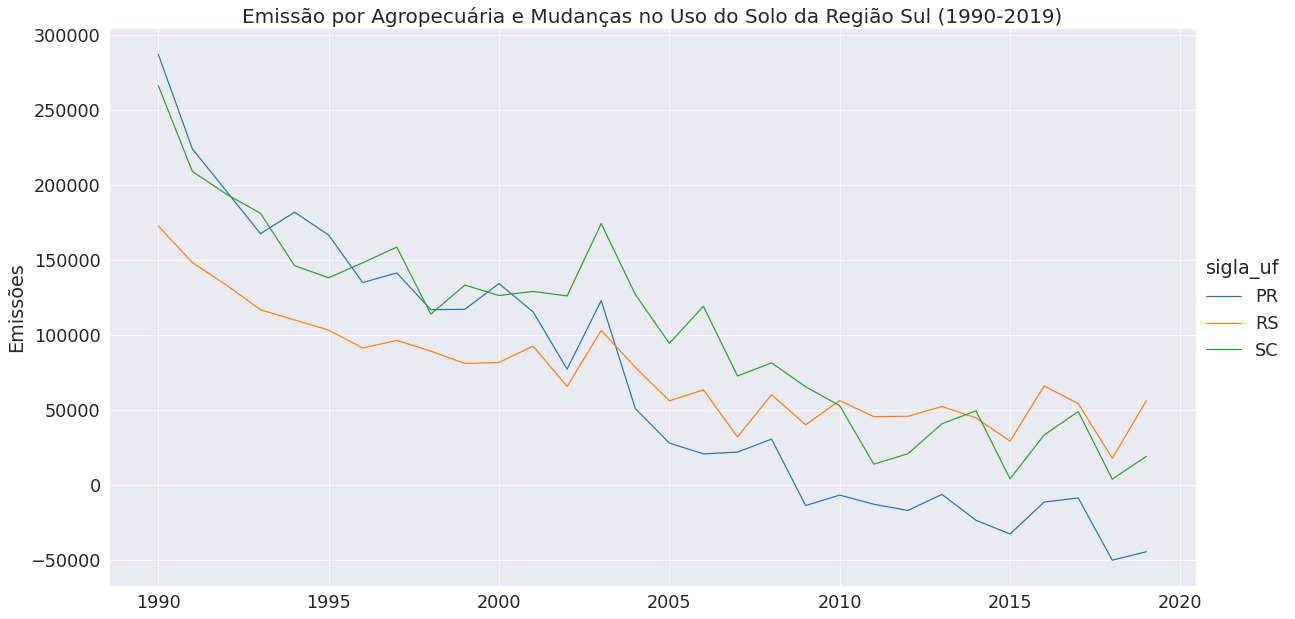

In [73]:
emissao_sul = taxas_emissoes[taxas_emissoes['sigla_uf'].isin(['PR', 'SC', 'RS'])]
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.relplot(x="ano", y="emissao", data=emissao_sul, ci=None, kind="line", hue ="sigla_uf", height = 9, aspect = 1.9)
plt.title('Emissão por Agropecuária e Mudanças no Uso do Solo da Região Sul (1990-2019)', y=1, fontsize = 20)
plt.xlabel('')
plt.ylabel('Emissões')
plt.show()

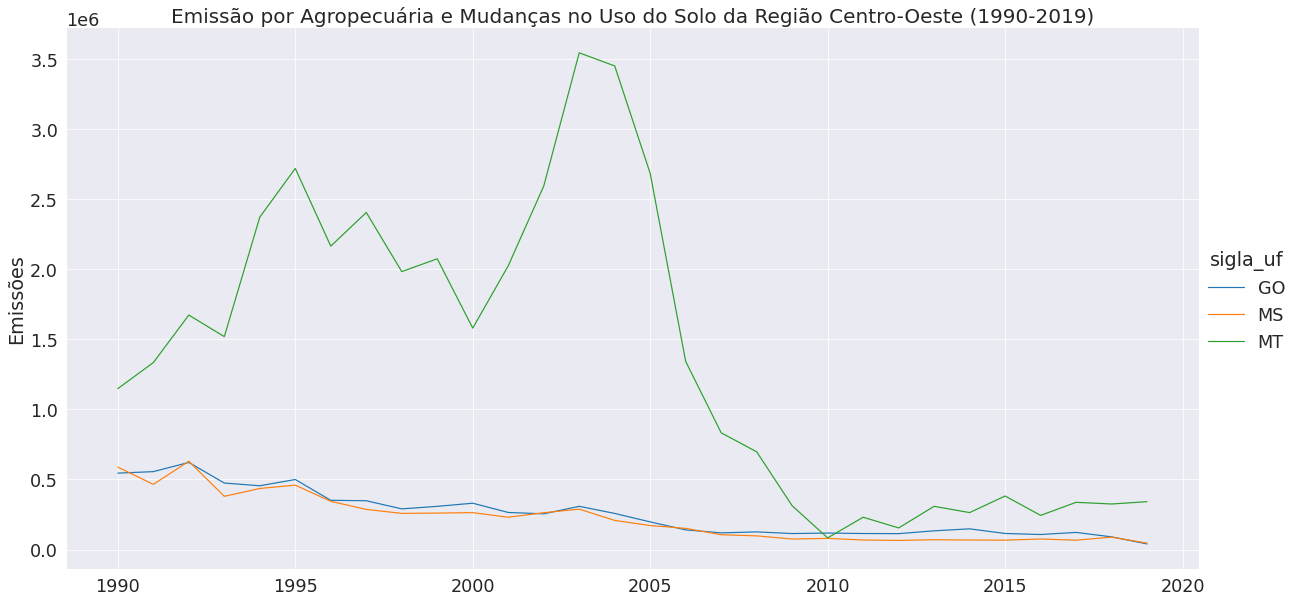

In [72]:
emissao_centooeste = taxas_emissoes[taxas_emissoes['sigla_uf'].isin(['GO', 'MT', 'MS'])]
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.relplot(x="ano", y="emissao", data=emissao_centooeste, ci=None, kind="line", hue ="sigla_uf", height = 9, aspect = 1.9)
plt.title('Emissão por Agropecuária e Mudanças no Uso do Solo da Região Centro-Oeste (1990-2019)', y=1, fontsize = 20)
plt.xlabel('')
plt.ylabel('Emissões')
plt.show()

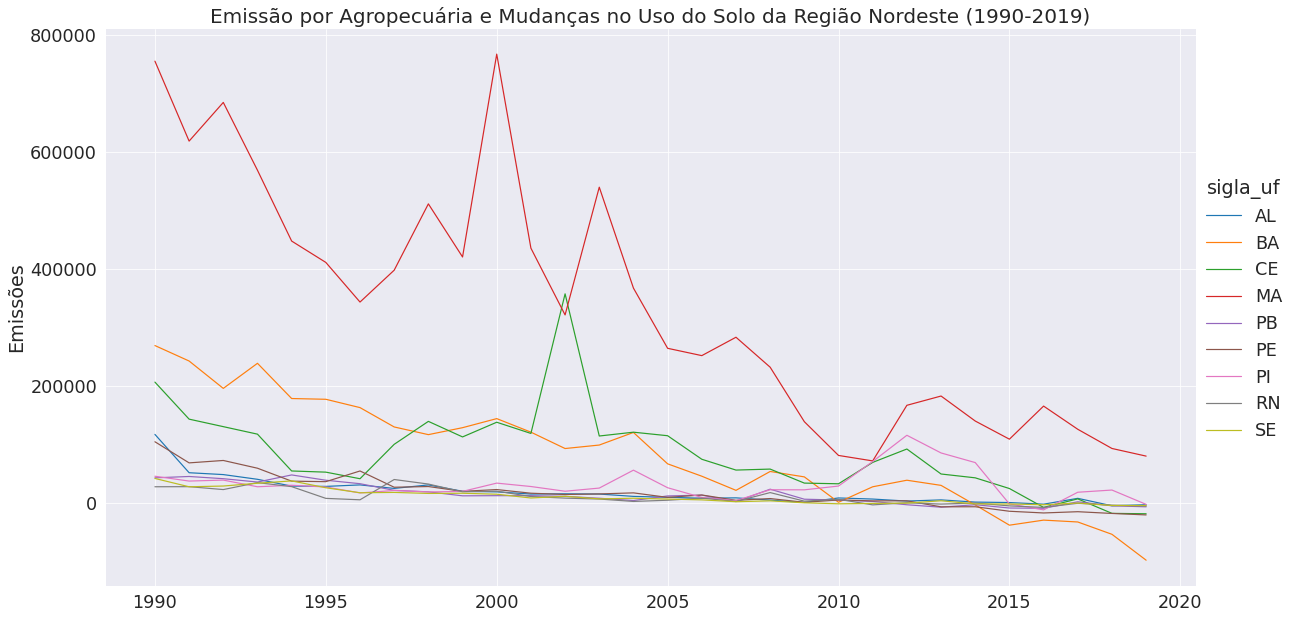

In [71]:
emissao_nordeste = taxas_emissoes[taxas_emissoes['sigla_uf'].isin(['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'])]
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.relplot(x="ano", y="emissao", data=emissao_nordeste, ci=None, kind="line", hue ="sigla_uf", height = 9, aspect = 1.9)
plt.title('Emissão por Agropecuária e Mudanças no Uso do Solo da Região Nordeste (1990-2019)', y=1, fontsize = 20)
plt.xlabel('')
plt.ylabel('Emissões')
plt.show()

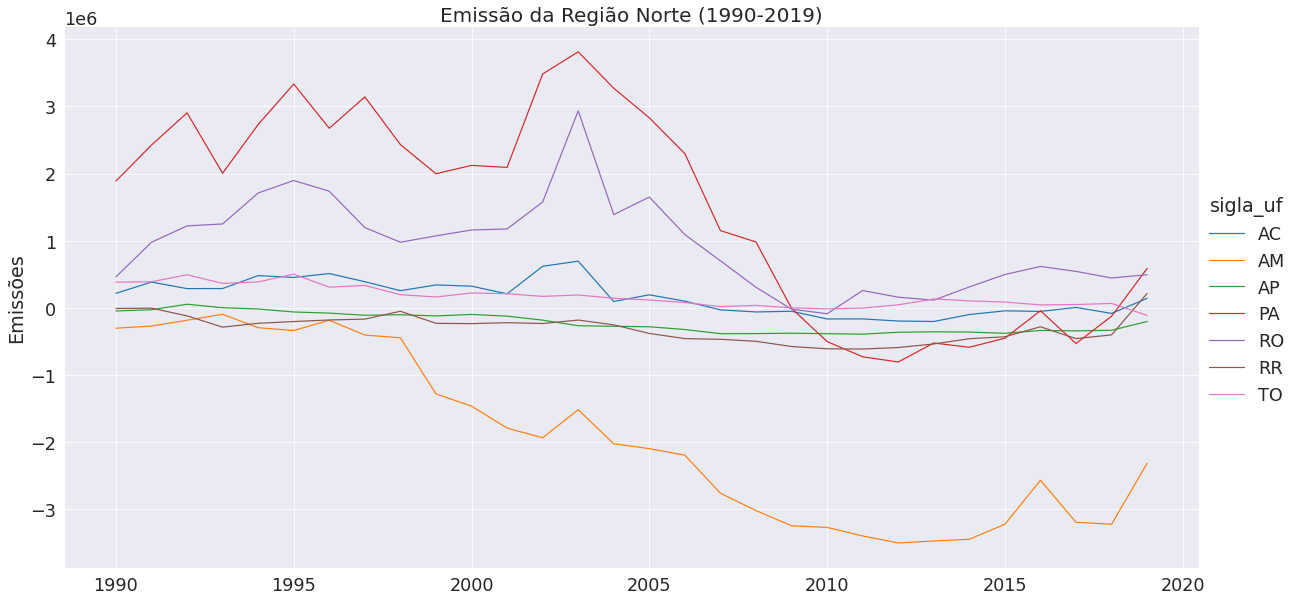

In [64]:
emissao_norte = taxas_emissoes[taxas_emissoes['sigla_uf'].isin(['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'])]
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
sns.relplot(x="ano", y="emissao", data=emissao_norte, ci=None, kind="line", hue ="sigla_uf", height = 9, aspect = 1.9)
plt.title('Emissão por Agropecuária e Mudanças no Uso do Solo da Região Norte (1990-2019)', y=1, fontsize = 20)
plt.xlabel('')
plt.ylabel('Emissões')
plt.show()

In [74]:
df_emissao_n0 =  gases_est.loc[(gases_est['ano'] > 1989) & (gases_est['ano'] < 1991)]
df_emissao_n0 = df_emissao_n0.groupby(['ano', 'sigla_uf'], as_index=False)['emissao'].sum()
df_emissao_n0 = df_emissao_n0.set_index('sigla_uf')
df_emissao_n0.head()

,ano,emissao
sigla_uf,,
AC,1990,7.743746e+07
AL,1990,7.335693e+07
AM,1990,-1.199342e+08
AP,1990,-2.235160e+07
BA,1990,4.267671e+08


In [75]:
popu90_est_dict = {'PA': 5181570, 'RO': 1130874, 'AC': 417165, 'AM': 2102901, 'RR': 215950, 'AP': 288690, 
             'MT': 2022524, 'MS': 1778741, 'GO': 4012562, 'TO': 920116, 'DF': 1598415, 'BA': 11855157, 
             'MA': 4929029, 'PI': 2581215, 'CE': 6362620, 'PE': 7122548, 'PB': 3200677, 'RN': 2414121, 
             'AL': 2512991, 'SE': 1491867, 'PR': 8443299, 'RS': 9135479, 'SC': 4538248,
             'SP': 31546473, 'MG': 1573961, 'ES': 2598505, 'RJ': 12783761}

popu90_estados = pd.DataFrame.from_dict(popu90_est_dict, orient='index')
estados = popu90_estados.index.tolist()
print(popu90_estados)

           0
PA   5181570
RO   1130874
AC    417165
AM   2102901
RR    215950
AP    288690
MT   2022524
MS   1778741
GO   4012562
TO    920116
DF   1598415
BA  11855157
MA   4929029
PI   2581215
CE   6362620
PE   7122548
PB   3200677
RN   2414121
AL   2512991
SE   1491867
PR   8443299
RS   9135479
SC   4538248
SP  31546473
MG   1573961
ES   2598505
RJ  12783761


In [76]:
for d in estados:
    df_emissao_n0.loc[d, 'emissao90 população'] = df_emissao_n0.loc[d,'emissao']/popu90_estados.loc[d][0]
df_emissao_n0

,ano,emissao,emissao90 população
sigla_uf,,,
AC,1990,7.743746e+07,185.627893
AL,1990,7.335693e+07,29.191084
AM,1990,-1.199342e+08,-57.032753
AP,1990,-2.235160e+07,-77.424241
BA,1990,4.267671e+08,35.998434
CE,1990,1.129306e+08,17.749073
DF,1990,1.610534e+07,10.075821
ES,1990,1.010958e+08,38.905386
GO,1990,4.450598e+08,110.916620


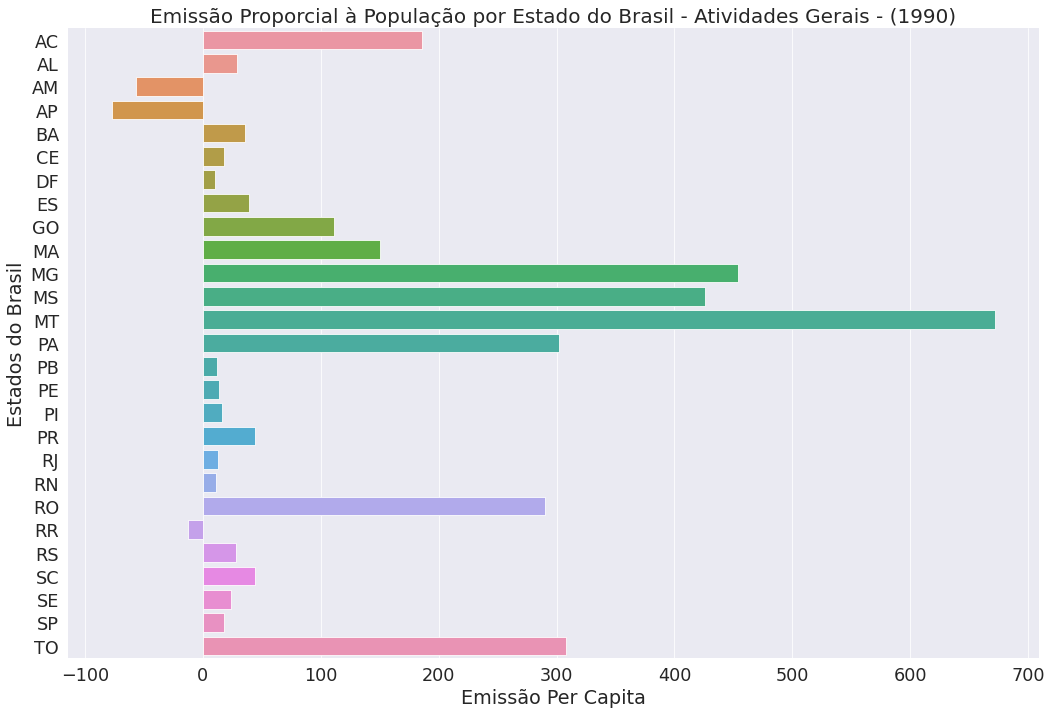

In [77]:
df_emissao_n0 = df_emissao_n0.reset_index()
sns.catplot(data=df_emissao_n0, kind='bar', x='emissao90 população', y='sigla_uf', height = 10, aspect = 1.5)
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=2)
plt.title('Emissão Proporcial à População por Estado do Brasil - Atividades Gerais - (1990)', y=1, fontsize = 20)
plt.xlabel('Emissão Per Capita')
plt.ylabel('Estados do Brasil')
plt.show()

In [78]:
df_emissao_n1 =  gases_est.loc[(gases_est['ano'] > 2018) & (gases_est['ano'] < 2020)]
df_emissao_n1 = df_emissao_n1.groupby(['ano', 'sigla_uf'], as_index=False)['emissao'].sum()
df_emissao_n1 = df_emissao_n1.set_index('sigla_uf')
df_emissao_n1.head()

,ano,emissao
sigla_uf,,
AC,2019,5.582760e+07
AL,2019,2.300523e+07
AM,2019,-9.471205e+08
AP,2019,-1.034339e+08
BA,2019,3.042583e+07


In [79]:
popu19_est_dict = {'PA': 8777124, 'RO': 1815278, 'AC': 906876, 'AM': 4269995, 'RR': 652713, 'AP': 877613, 
             'MT': 3567234, 'MS': 2839188, 'GO': 7206589, 'TO': 1607363, 'DF': 3094325, 'BA': 14985284, 
             'MA': 7153262, 'PI': 3289290, 'CE': 9240580, 'PE': 9674793, 'PB': 4059905, 'RN': 3560903, 
             'AL': 3365351, 'SE': 2338474	, 'PR': 11597484, 'RS': 11466630, 'SC': 7338473,
             'SP': 46649132, 'MG': 21411923	, 'ES': 4108508, 'RJ': 17463349}

popu19_estados = pd.DataFrame.from_dict(popu19_est_dict, orient='index')
estados_19 = popu19_estados.index.tolist()
print(popu19_estados)

           0
PA   8777124
RO   1815278
AC    906876
AM   4269995
RR    652713
AP    877613
MT   3567234
MS   2839188
GO   7206589
TO   1607363
DF   3094325
BA  14985284
MA   7153262
PI   3289290
CE   9240580
PE   9674793
PB   4059905
RN   3560903
AL   3365351
SE   2338474
PR  11597484
RS  11466630
SC   7338473
SP  46649132
MG  21411923
ES   4108508
RJ  17463349


In [80]:
for p in estados_19:
    df_emissao_n1.loc[p, 'emissao19 população'] = df_emissao_n1.loc[p,'emissao']/popu19_estados.loc[p][0]
df_emissao_n1

,ano,emissao,emissao19 população
sigla_uf,,,
AC,2019,5.582760e+07,61.560347
AL,2019,2.300523e+07,6.835909
AM,2019,-9.471205e+08,-221.808339
AP,2019,-1.034339e+08,-117.858182
BA,2019,3.042583e+07,2.030381
CE,2019,9.484803e+07,10.264294
DF,2019,3.316553e+07,10.718179
ES,2019,1.445942e+08,35.193840
GO,2019,1.268028e+08,17.595396


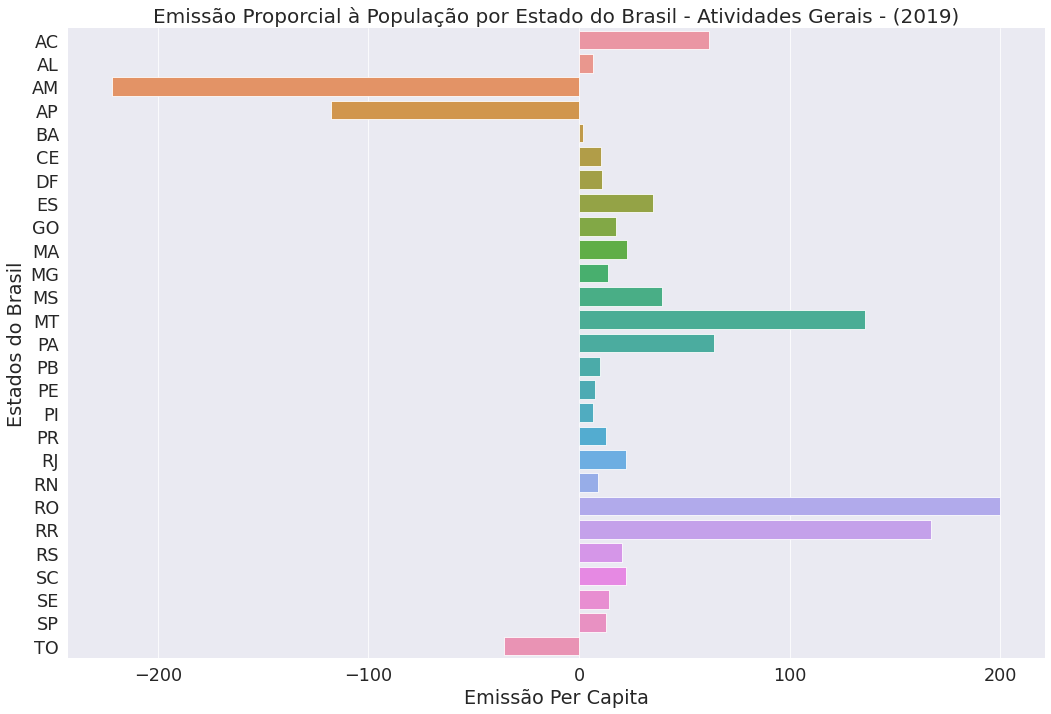

In [81]:
df_emissao_n1 = df_emissao_n1.reset_index()
sns.catplot(data=df_emissao_n1, kind='bar', x='emissao19 população', y='sigla_uf', height = 10, aspect = 1.5)
sns.set_style("darkgrid")
sns.set_context('paper', font_scale=1.5)
plt.title('Emissão Proporcial à População por Estado do Brasil - Atividades Gerais - (2019)', y=1, fontsize = 20)
plt.xlabel('Emissão Per Capita')
plt.ylabel('Estados do Brasil')
plt.show()

In [82]:
gases_atividades_gerais = gases_est
gases_atividades_gerais = gases_atividades_gerais.loc[(gases_atividades_gerais['ano'] > 1989) & (gases_atividades_gerais['ano'] < 2020)]

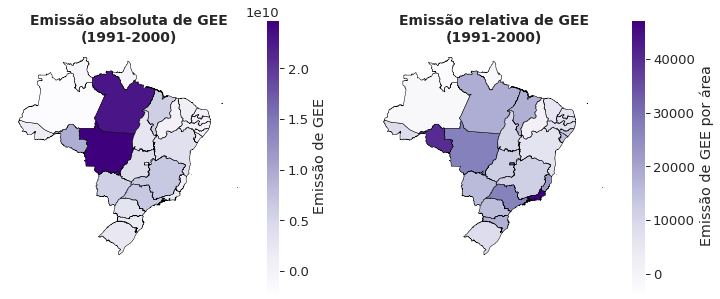

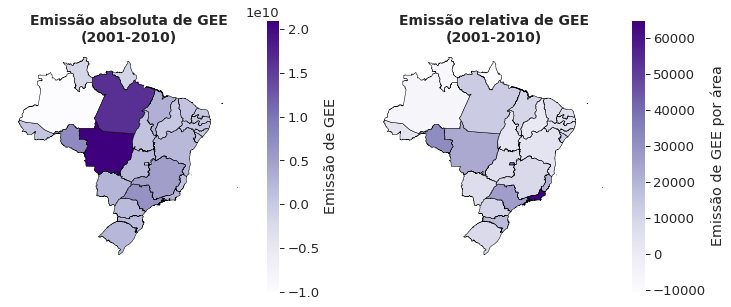

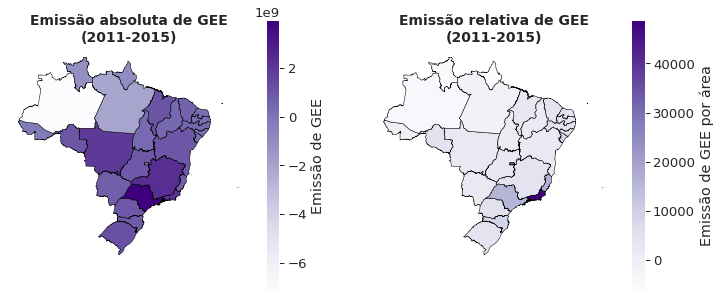

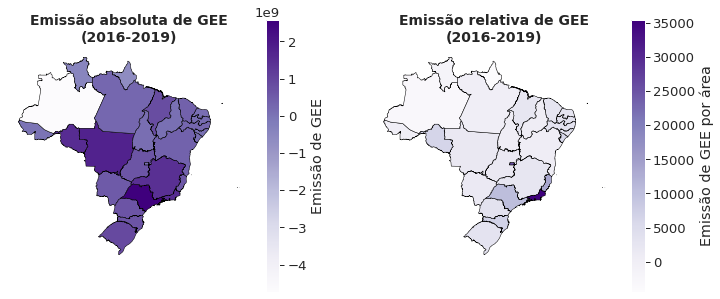

In [83]:
##PLOTANDO MAPAS DE EMISSOES TOTAIS POR ESTADO E POR DECADA##
gee_gerais = gases_atividades_gerais.set_index('sigla_uf')

#Agrupando os dados de emissao entre decadas

# Entre 1990-2000

df_gee_90_00 = gee_gerais.loc[gee_gerais['ano'] < 2001][['emissao']].groupby('sigla_uf').sum()
df_gee_90_00['decada'] = '1991-2000'

# Entre 2001-2010

df_gee_01_10 = gee_gerais.loc[(gee_gerais['ano'] > 2000) & (gee_gerais['ano'] < 2011)][['emissao']].groupby('sigla_uf').sum()
df_gee_01_10['decada'] = '2001-2010'

#Entre 2011-2015

df_gee_11_15 = gee_gerais.loc[(gee_gerais['ano'] > 2010) & (gee_gerais['ano'] < 2016)][['emissao']].groupby('sigla_uf').sum()
df_gee_11_15['decada'] = '2011-2015'


#Entre 2016-2019
df_gee_16_20 = gee_gerais.loc[(gee_gerais['ano'] > 2015) & (gee_gerais['ano'] < 2020)][['emissao']].groupby('sigla_uf').sum()
df_gee_16_20['decada'] = '2016-2019'

df_gee_acum = df_gee_90_00.append(df_gee_01_10).append(df_gee_11_15).append(df_gee_16_20)

#Calculando as emissoes por unidade de area de cada estado

for x in estados:
  df_gee_acum.loc[x, 'emi_area'] = df_gee_acum.loc[x,'emissao']/area_estados.loc[x][0]

gdf_gee_acum = df_gee_acum.merge(gdf_estados, on='sigla_uf').drop(
    columns=['CD_UF', 'NM_REGIAO', 'NM_UF'])

gdf_gee_acum = GeoDataFrame(gdf_gee_acum)


for ano in gdf_gee_acum['decada'].unique():
  fig, ax = plt.subplots(1, 2, figsize=[12, 5])
  x = gdf_gee_acum.loc[gdf_gee_acum['decada'] == ano]
  x.set_index('sigla_uf', inplace=True)
  x.plot(column='emissao', edgecolor="black", cmap='Purples',
                    ax=ax[0], legend=True,linewidth=0.5, 
                    legend_kwds={'label': "Emissão de GEE"})
  ax[0].set_axis_off()
  ax[0].set_title(f'Emissão absoluta de GEE\n({ano})', fontdict={'fontsize': 14,
 'fontweight' : 'semibold'})
  x.plot(column='emi_area', edgecolor="black", cmap='Purples',
         ax=ax[1], legend=True, linewidth=0.5, 
         legend_kwds={'label': "Emissão de GEE por área"})
  ax[1].set_axis_off()
  ax[1].set_title(f'Emissão relativa de GEE\n({ano})', fontdict={'fontsize': 14,
 'fontweight' : 'semibold'})
  plt.show()